In [296]:
%matplotlib inline

In [297]:
from __future__ import unicode_literals, division

import IPython
import warnings
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from pylab import *
from IPython.display import HTML
from IPython.display import display as prnt
from statsmodels.formula.api import ols

# Notebook Options
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

# Matplotlib Styles
c = {'axes.labelsize': 17,
'axes.titlesize': 16,
'figure.figsize': [18, 8],
'grid.linewidth': 1.6,
'legend.fontsize': 17,
'lines.linewidth': 2,
'lines.markeredgewidth': 0.0,
'lines.markersize': 11,
'patch.linewidth': 0.5,
'xtick.labelsize': 16,
'xtick.major.pad': 20,
'xtick.major.width': 2,
'xtick.minor.width': 1,
'ytick.labelsize': 16.0,
'ytick.major.pad': 20,
'ytick.major.width': 2,
'ytick.minor.width': 1 }
wide_c = dict(c, **{'figure.figsize':[20,8]})

#### Utility Functions

In [298]:
def table(df,replace_match="",replace_str=""):
    return IPython.display.display(HTML(df.to_html().replace('<table border="1" class="dataframe">','<table class="table table-striped table-hover">').replace(replace_match,replace_str)))

### Load the Data

In [299]:
df = pd.read_csv("DSdataset.csv", sep=',')

### Inspect the Data

In [300]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25447 entries, 0 to 25446
Data columns (total 46 columns):
AI                     25447 non-null int64
Date                   25447 non-null object
Time                   25447 non-null object
TapNumber              25447 non-null int64
SKU                    25183 non-null float64
Product                25184 non-null object
Volume                 25447 non-null float64
Volume Unit            25183 non-null object
Charge                 25447 non-null float64
PricePerViolCharged    25447 non-null float64
PricePerVolume         25447 non-null float64
HHPricePerVolume       25447 non-null float64
Currency Unit          25183 non-null object
CardNumber             25447 non-null int64
CardType               25183 non-null object
CardStatus             559 non-null object
OriginGroup            25189 non-null object
OriginUnit             25188 non-null object
SerialNumber           25183 non-null object
SoftwareVersion        25441 non-nu

In [301]:
table(df.head())

,AI,Date,Time,TapNumber,SKU,Product,Volume,Volume Unit,Charge,PricePerViolCharged,PricePerVolume,HHPricePerVolume,Currency Unit,CardNumber,CardType,CardStatus,OriginGroup,OriginUnit,SerialNumber,SoftwareVersion,SystemRole,Mode,AreaID,AreaDesc,LineTemp,CoolerTemp,TempScale,FaultTrip,ContainerSize,ContainerLevel,Name,Phone,Email,DOB,Gender,Address,VolumeRemain,PrePaidRemain,PrePaidVolRemain,ID,mediaID,mediaType,mediaDesc,mediaPoolID,PourScreenID,PourScreenDesc
0,1,07/04/15,07:01:32,1,NaN,NaN,4.60,NaN,1.47,0.32,0.32,0.32,NaN,850,NaN,NaN,NaN,NaN,NaN,3.17,Satellite,Sale,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0000-00-00,NaN,NaN,0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2,07/04/15,07:01:40,1,NaN,NaN,1.98,NaN,0.63,0.32,0.32,0.32,NaN,231,NaN,NaN,NaN,NaN,NaN,3.17,Satellite,Sale,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0000-00-00,NaN,NaN,0,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN
2,3,07/04/15,07:02:17,1,NaN,NaN,7.14,NaN,2.29,0.32,0.32,0.32,NaN,850,NaN,NaN,NaN,NaN,NaN,3.17,Satellite,Sale,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0000-00-00,NaN,NaN,0,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN
3,4,07/04/15,07:02:39,1,NaN,NaN,5.36,NaN,1.71,0.32,0.32,0.32,NaN,850,NaN,NaN,NaN,NaN,NaN,3.17,Satellite,Sale,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0000-00-00,NaN,NaN,0,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
4,5,07/04/15,11:02:50,1,NaN,NaN,4.50,NaN,1.44,0.32,0.32,0.32,NaN,850,NaN,NaN,NaN,NaN,NaN,3.17,Master,Sale,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0000-00-00,NaN,NaN,0,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN


### Drop unusable columns

In [302]:
df = df.dropna(axis=1,how='all')

In [303]:
print df['Volume Unit'].unique()
print df['Currency Unit'].unique()
print df['ContainerSize'].unique()
print df['DOB'].unique()
print df['ContainerLevel'].unique()

[nan 'oz' 'Oz.']
[nan '$']
[0]
['0000-00-00']
[0]


We can see that 

* volume is measured in oz 
* currency is measured in dollars
* ContainerSize is a list of 0s
* DOB only has 0

So we can drop these columns too

In [304]:
df.drop(['Volume Unit', 'Currency Unit', 'ContainerSize', 'DOB', 'ContainerLevel'],inplace=True,axis=1)

### Convert dates to datetime objects

In [305]:
FullDate = df.Date.map(lambda x: x) + " " + df.Time.map(lambda x: x)

In [306]:
for x in range(0, len(df['Date'])):
    df['Time'][x] = pd.to_datetime(FullDate[x], dayfirst=True)

In [307]:
df['Time'].ix[0:5]

0   2015-04-07 07:01:32
1   2015-04-07 07:01:40
2   2015-04-07 07:02:17
3   2015-04-07 07:02:39
4   2015-04-07 11:02:50
5   2015-04-07 11:03:18
Name: Time, dtype: datetime64[ns]

In [308]:
df['Time'].describe()

count                   25447
unique                  23642
top       2015-04-11 14:07:41
freq                        6
dtype: object

The column is not completely datetime64, and so we still need to clean up the non converted rows

In [309]:
for x in range(0, len(df['Date'])):
    if type(df['Time'][x]) == pd.tslib.Timestamp:
        continue
    else:
        print "Row " + str(x) + " has a timestamp of " + str(df['Time'][x])

Row 2464 has a timestamp of 0000-00-00 00:00:00
Row 2655 has a timestamp of 0000-00-00 00:00:00
Row 20451 has a timestamp of 0000-00-00 00:00:00
Row 20452 has a timestamp of 0000-00-00 00:00:00
Row 20453 has a timestamp of 0000-00-00 00:00:00


In [310]:
pd.options.display.max_columns = 25
dfInspect = df[df['Time'] == "0000-00-00 00:00:00"]
table(dfInspect)

,AI,Date,Time,TapNumber,SKU,Product,Volume,Charge,PricePerViolCharged,PricePerVolume,HHPricePerVolume,CardNumber,CardType,CardStatus,OriginGroup,OriginUnit,SerialNumber,SoftwareVersion,SystemRole,Mode,Name,VolumeRemain,PrePaidRemain,ID
2464,98,0000-00-00,0000-00-00 00:00:00,0,NaN,NaN,0,0,0,0,0,0,NaN,NaN,NaN,test from reds,NaN,NaN,NaN,NaN,NaN,0,NaN,2465
2655,289,0000-00-00,0000-00-00 00:00:00,0,NaN,NaN,0,0,0,0,0,0,NaN,NaN,test from reds,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,2656
20451,15,0000-00-00,0000-00-00 00:00:00,0,NaN,NaN,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,20457
20452,16,0000-00-00,0000-00-00 00:00:00,0,NaN,NaN,0,0,0,0,0,0,NaN,NaN,test from indians,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,20458
20453,17,0000-00-00,0000-00-00 00:00:00,0,NaN,NaN,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,20459


From inspecting the above rows I can see that these rows have blank data and so I can remove them

In [311]:
df = df[df['Time'] != "0000-00-00 00:00:00"]

In [312]:
for index, row in df.iterrows():
    try: 
        if type(df['Time'][x]) == pd.tslib.Timestamp:
            continue
        else:
            print "Row " + str(x) + " has a timestamp of " + str(df['Time'][x])
    except:
        pass

### Convert product categories into numeric data

Give each product a brand number

In [564]:
products = sorted(df['Product'].unique())
for x in range(0, len(products)):
    print str(x) + " is " + str(products[x])

0 is nan
1 is BLACK BOX PLUMBERS CRACK
2 is BREW KETTLE 4CS
3 is BUCKEYE BREWING IPA
4 is BUTCHER & BREWER KOLSCH
5 is Blue Point Toasted Lager
6 is Bud Light
7 is Budweiser
8 is CROOKED RIVER SETTLERS ALE
9 is FAT HEAD`S HEAD HUNTER
10 is GREAT LAKES RALLY DRUM
11 is Goose Island 312
12 is Goose Island IPA
13 is Heineken
14 is MARKET GARDEN CITRAMAX
15 is Michelob Golden
16 is Nordeast Grain Belt
17 is PLATFORM PALESNER
18 is PORTSIDE 216
19 is Shock Top
20 is Stella Artois
21 is Summit EPA
22 is Sweetwater 420
23 is Sweetwater IPA
24 is TD LABRADOR LAGER
25 is WILLOUGHBY PEANUT BUTTER CUP


In [314]:
df_product = pd.get_dummies(df.Product)

In [315]:
len(df_product.columns)

25

In [316]:
brands = list(xrange(1,26))
df_product.columns = brands

In [317]:
for x in range(0, len(df_product)):
    for y in range(0, len(df_product.columns)):
        if df_product.iloc[x, y] == 1:
            df_product.iloc[x, y] = y+1

In [318]:
df["Brand"] = df_product.sum(axis=1)

In [357]:
from random import sample
table(df[['Product', 'Brand']].ix[sample(df.index,5)])

,Product,Brand
10074,Budweiser,7
7471,Goose Island IPA,12
20303,Blue Point Toasted Lager,5
8529,Bud Light,6
6776,Goose Island IPA,12


In [320]:
y = 0
for x in range(0, len(df.Brand)):
    try:
        if df.Brand[x] == 0:
            y += 1
        else:
            continue
    except:
        pass
print "There are " + str(y) + " instances of the Brand being undefined"

There are 258 instances of the Brand being undefined


# EDA

### Univariate

In [321]:
table(df.describe())

,AI,TapNumber,SKU,Volume,Charge,PricePerViolCharged,PricePerVolume,HHPricePerVolume,CardNumber,SoftwareVersion,VolumeRemain,PrePaidRemain,ID,Brand
count,25442.000000,25442.000000,25183.000000,25442.000000,25442.000000,25442.000000,25442.000000,25442.000000,25442.000000,25441.000000,25442.000000,22067.000000,25442.000000,25442.000000
mean,5600.452166,1.427875,10001.552476,14.911554,6.177599,0.428539,0.428539,0.331853,50875.553534,3.156578,22.993996,7.764131,12727.098616,8.730682
std,4917.908566,0.494860,1.021343,6.529932,2.807547,0.067309,0.067309,0.055416,11548.782597,0.045849,14.905906,9.637402,7347.544120,5.365991
min,1.000000,0.000000,10001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,1.000000,0.000000
25%,1339.000000,1.000000,10001.000000,10.240000,4.230000,0.390000,0.390000,0.320000,49770.000000,3.170000,11.950000,1.400000,6366.250000,6.000000
50%,3668.500000,1.000000,10001.000000,15.790000,6.670000,0.390000,0.390000,0.320000,52398.000000,3.170000,25.980000,6.060000,12726.500000,6.000000
75%,9713.750000,2.000000,10002.000000,20.020000,8.190000,0.450000,0.450000,0.320000,54945.000000,3.170000,32.430000,11.540000,19088.750000,10.000000
max,16076.000000,2.000000,10006.000000,48.670000,23.330000,0.560000,0.560000,0.560000,65800.000000,3.180000,63.000000,96.040000,25452.000000,25.000000


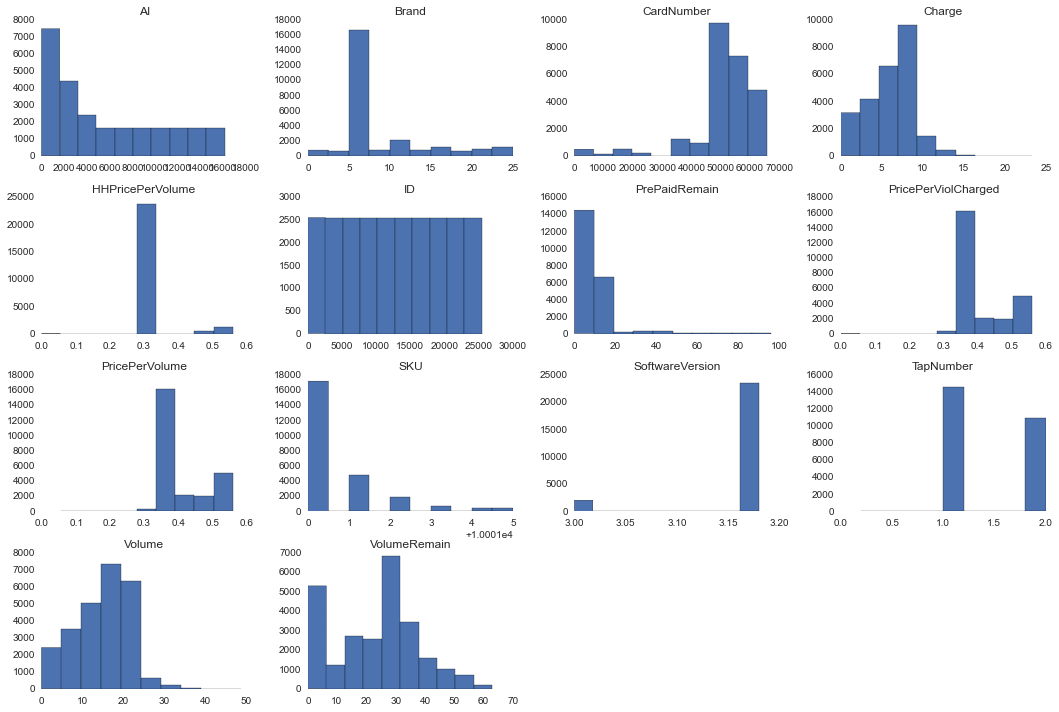

In [322]:
df.hist(figsize=(18,12))
plt.show()

### Reducing data to look at specific and relevant attributes

In [323]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25442 entries, 0 to 25446
Data columns (total 25 columns):
AI                     25442 non-null int64
Date                   25442 non-null object
Time                   25442 non-null object
TapNumber              25442 non-null int64
SKU                    25183 non-null float64
Product                25184 non-null object
Volume                 25442 non-null float64
Charge                 25442 non-null float64
PricePerViolCharged    25442 non-null float64
PricePerVolume         25442 non-null float64
HHPricePerVolume       25442 non-null float64
CardNumber             25442 non-null int64
CardType               25183 non-null object
CardStatus             559 non-null object
OriginGroup            25187 non-null object
OriginUnit             25187 non-null object
SerialNumber           25183 non-null object
SoftwareVersion        25441 non-null float64
SystemRole             25441 non-null object
Mode                   25441 non-n

In [29]:
df1 = df[['Date', 'Time', 'TapNumber', 'Brand', 'Volume', 'Charge', 'PricePerVolume', 'VolumeRemain', 'PrePaidRemain', 'CardNumber', 'CardType', 'OriginGroup', 'OriginUnit', 'Product']]

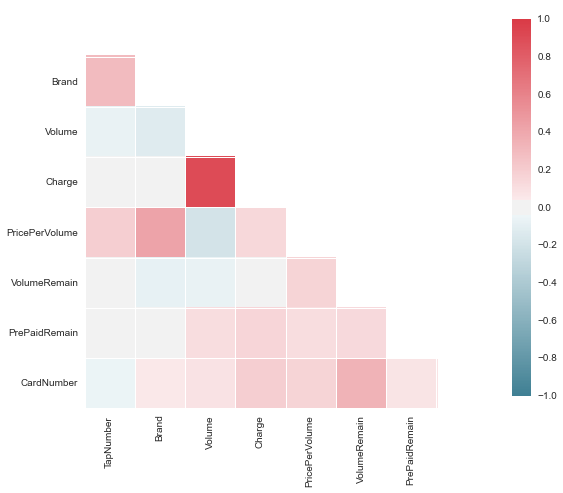

In [30]:
f, ax = plt.subplots(figsize=(9, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.corrplot(df1, annot=False, sig_stars=False,
             diag_names=False, cmap=cmap, ax=ax);

For obvious reasons there is a very strong correlation between the volume of beer poured and the charge for that pour.  There is also a strong relationship between the Brand and the PricePerVolume as I would imagine that beers are chared at a set price.

Interestingly, there is not a strong relationship between the VolumeRemain and the PrePaidRemain.  This is surprising as these should be directly correlated - amount of money left on the card should relate to the volume able to be poured.

My hypothesis is that there are promotional deals in place that gives some cards additional beer on top of what the user pays for.  TBC...

### Checking for normality

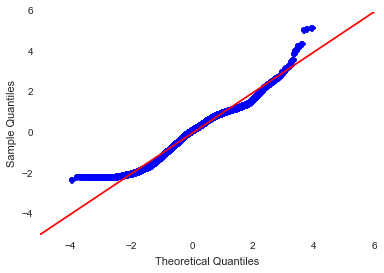

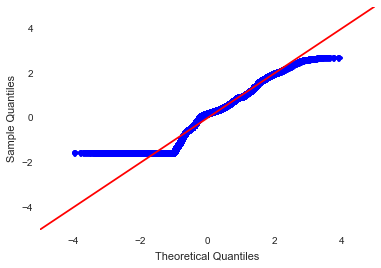

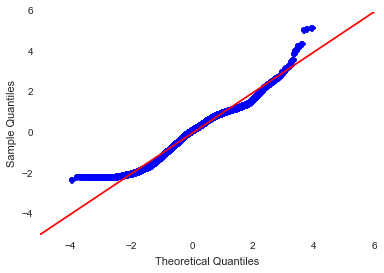

In [337]:
from statsmodels.graphics.gofplots import qqplot

qqplot(df1['VolumeRemain'], line='45', fit=True)
qqplot(df1['Volume'], line='45', fit=True)

**NOTE:  I'm not entirely sure what I should do with the above information....**

### Bivariate

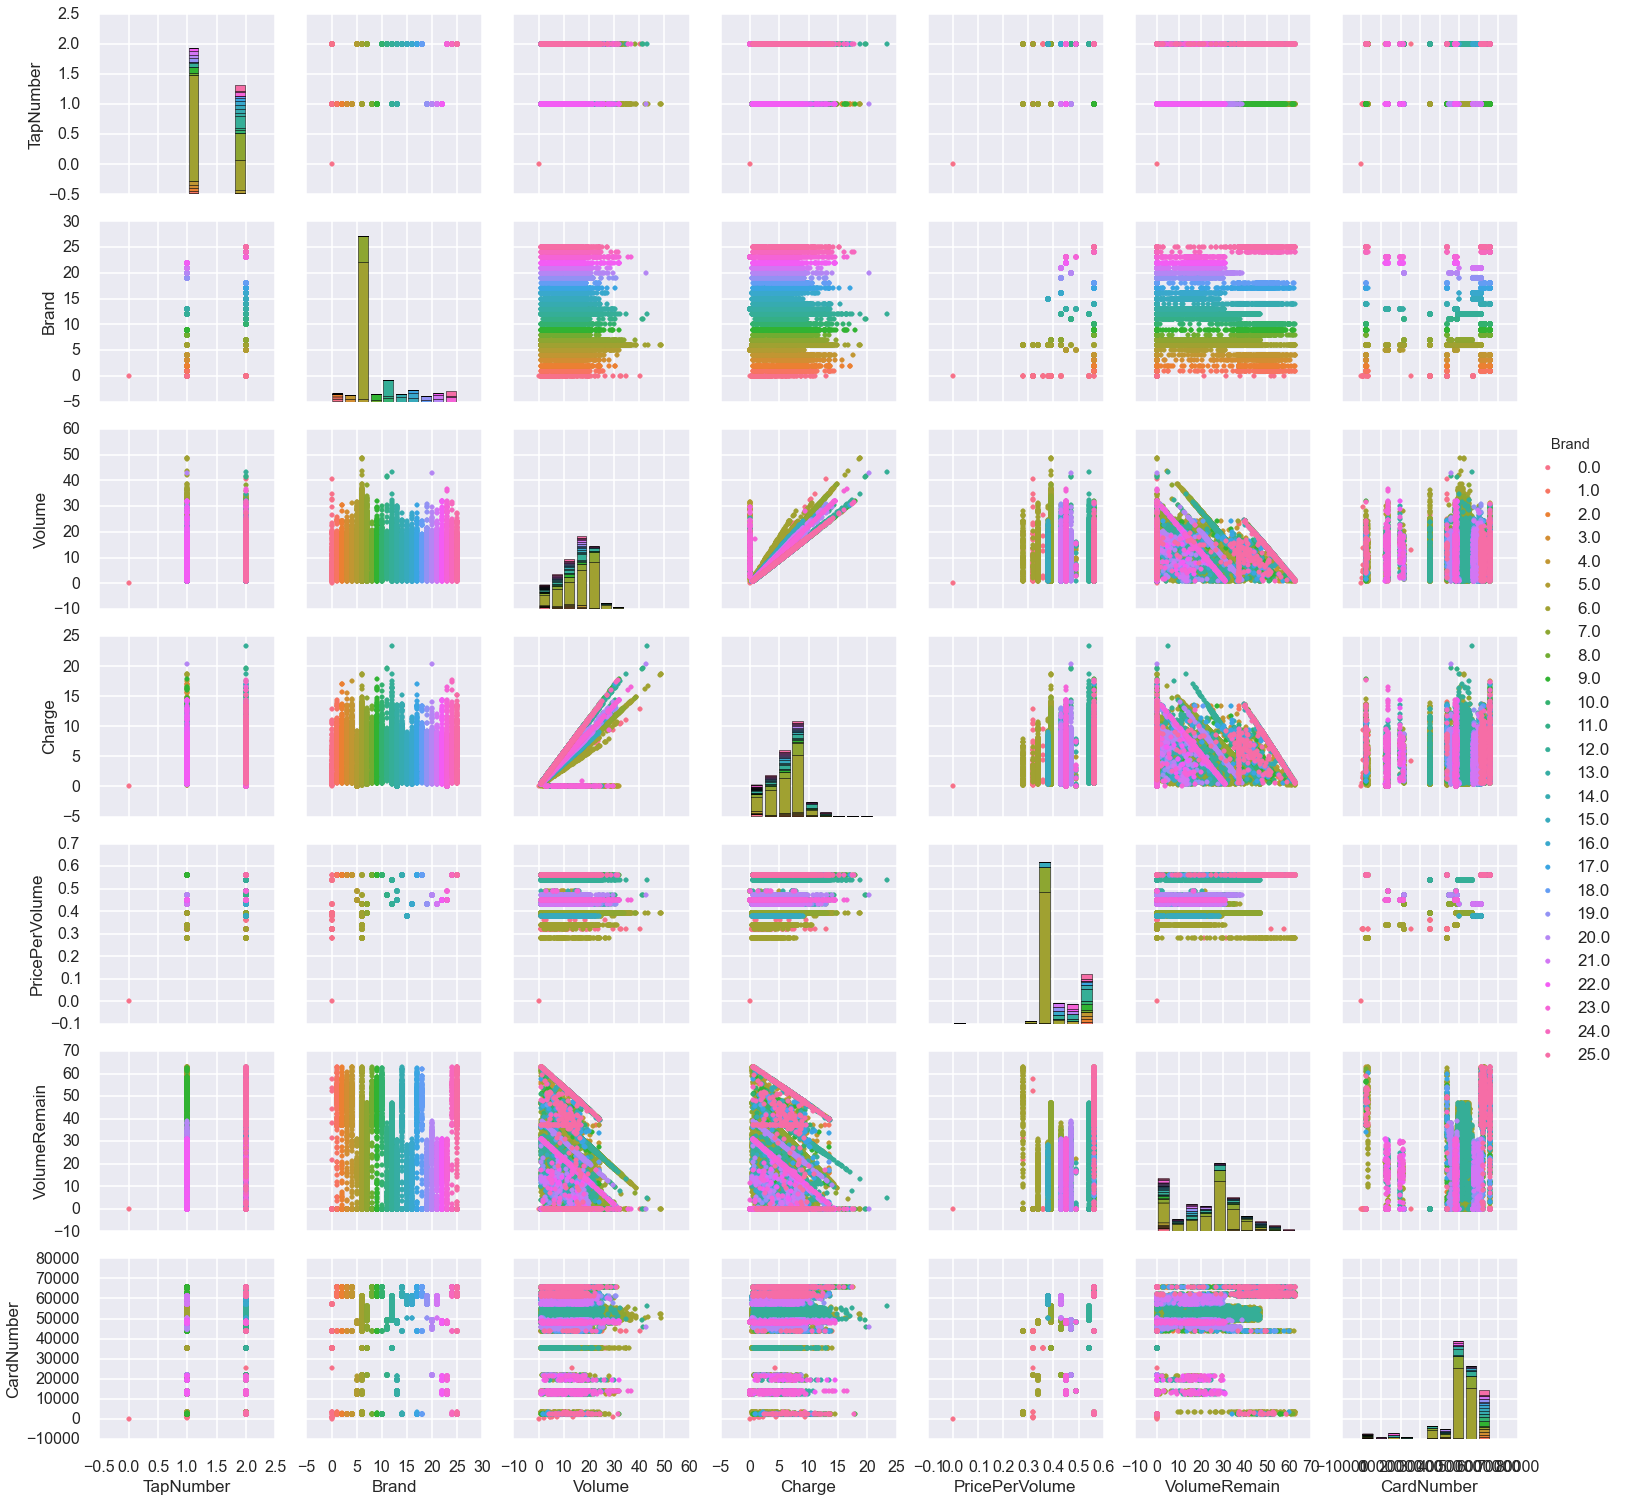

In [100]:
b, g, r, p = sns.color_palette("muted", 4)
dfbiV2 = df1.drop(['PrePaidRemain'], axis=1)

with sns.plotting_context("poster", font_scale=1, rc=c):
    g = sns.PairGrid(dfbiV2, hue="Brand")
    g.map_diag(plt.hist)
    g.map_offdiag(plt.scatter)
    g.add_legend()

### Looking at the Volume of beer poured

In [33]:
df1['Volume'].describe()

count    25442.000000
mean        14.911554
std          6.529932
min          0.000000
25%         10.240000
50%         15.790000
75%         20.020000
max         48.670000
dtype: float64

There are 16 oz in a pint and we can see that on average users pour just under a pint, at 14.9 oz.  
25% of pours are greater than 20 oz meaning that these users must have cups that are larger than pints.

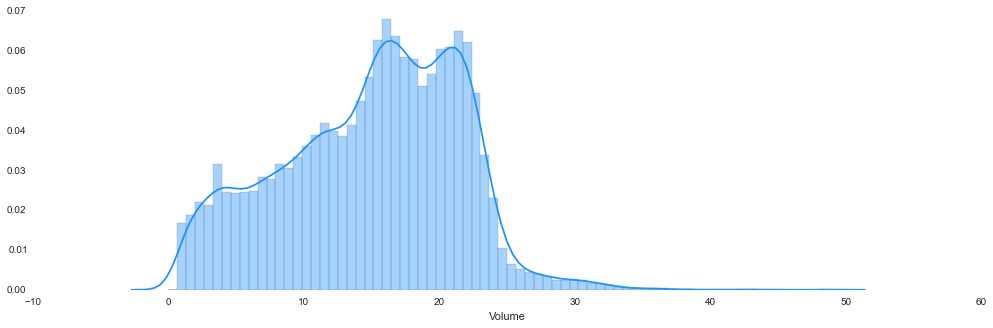

In [556]:
f, axes = plt.subplots(figsize=(17, 5))
sns.distplot(df['Volume'], color="dodgerblue");

The above histogram is bi-modal, with two distinct peaks in volume poured:

* At around the 16oz mark (1 pint)
* At around the 23oz mark

My hypothesis is that this is due to different cup sizes being used

### Comparing how volume of beer poured varies by price

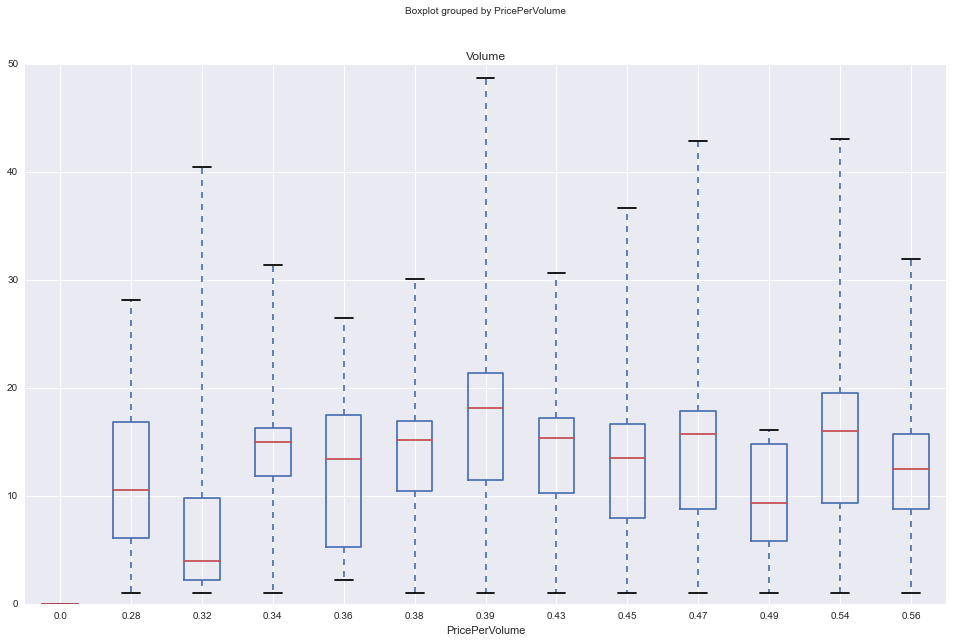

In [294]:
df.boxplot(column='Volume', by='PricePerVolume', figsize=(16,10));

### VolumeRemain and PrePaidRemain relationships

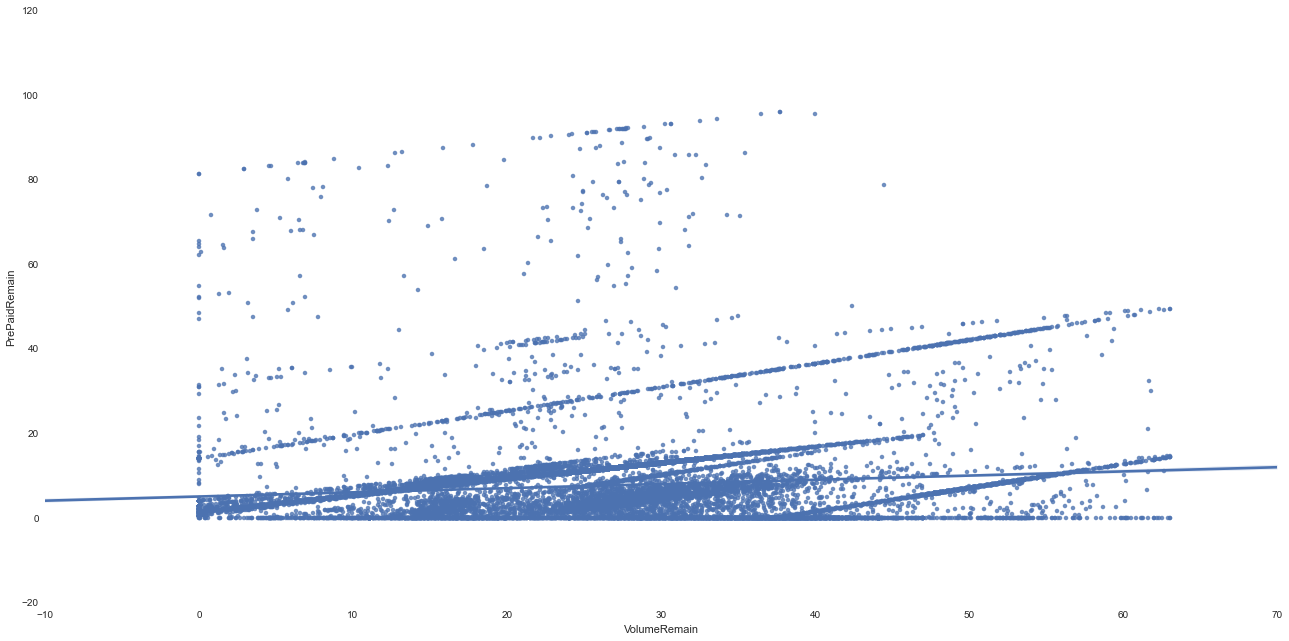

In [562]:
sns.lmplot('VolumeRemain', 'PrePaidRemain', df1, size=9, aspect=2);

The straight lines suggest a linear relationship (as expected), with different lines representing the cost of different brands.  However, there are clearly many anomalies that I assume are due to promotions, but that need explaining.

### Inspecting the impact of brand

Every location only stocks a set number of beers.  Firstly let's determine which beers are being stocked where:

In [39]:
for x in range(0, len(df.OriginGroup.unique())):
    dfOrigin = df.loc[df['OriginGroup'] == df.OriginGroup.unique()[x]]
    print str(df.OriginGroup.unique()[x]) + ":"
    for x in range(0, len(dfOrigin.Product.unique())):
        print "   - " + str(dfOrigin.Product.unique()[x])

nan:
ab.onpremise:
   - Goose Island IPA
   - Bud Light
   - Michelob Golden
   - Summit EPA
   - Nordeast Grain Belt
   - Shock Top
   - nan
   - Budweiser
philips.arena:
   - Bud Light
   - Sweetwater IPA
   - Heineken
   - Blue Point Toasted Lager
   - Sweetwater 420
testp:
   - nan
test1:
   - nan
DNC:
   - Bud Light
   - GREAT LAKES RALLY DRUM
   - BUCKEYE BREWING IPA
   - BREW KETTLE 4CS
   - FAT HEAD`S HEAD HUNTER
   - PLATFORM PALESNER
   - TD LABRADOR LAGER
   - BUTCHER & BREWER KOLSCH
   - WILLOUGHBY PEANUT BUTTER CUP
   - MARKET GARDEN CITRAMAX
   - BLACK BOX PLUMBERS CRACK
   - CROOKED RIVER SETTLERS ALE
   - PORTSIDE 216
ab.naz:
   - Bud Light
   - Budweiser
   - Stella Artois
   - Goose Island 312


As a bit more info on each arena:

* Philips Arena is an indoor sports arena and home of the Atlanta Hawks
* DNC refers to the Cleveland Indians baseball team at Progressive Field
* ab.onpremises refers to two baseball stadiums: 
    * the Cincinnati Reds baseball team who play at the Great American Ball Park 
    * the Minnesota Twins who play at Target Field
* ab.naz refers to...

In [40]:
for x in range(0, len(df.OriginUnit.unique())):
    dfOrigin = df.loc[df['OriginUnit'] == df.OriginUnit.unique()[x]]
    print str(df.OriginUnit.unique()[x]) + ":"
    for x in range(0, len(dfOrigin.Product.unique())):
        print "   - " + str(dfOrigin.Product.unique()[x])

nan:
twins01.r:
   - Goose Island IPA
   - Bud Light
twins02.l:
   - Michelob Golden
   - Shock Top
twins03.l:
   - Summit EPA
   - Nordeast Grain Belt
twins03.r:
   - Summit EPA
   - Nordeast Grain Belt
twins02.r:
   - Michelob Golden
   - Shock Top
twins01.l:
   - Bud Light
   - Goose Island IPA
reds10.r:
   - nan
   - Goose Island IPA
   - Bud Light
reds13.l:
   - Bud Light
   - Budweiser
reds06.r:
   - Bud Light
reds20.l:
   - Bud Light
   - Budweiser
reds07.r:
   - Bud Light
reds20.r:
   - Budweiser
   - Bud Light
reds06.l:
   - Bud Light
reds19.r:
   - Bud Light
   - Budweiser
reds19.l:
   - Bud Light
   - Budweiser
reds12.l:
   - Bud Light
   - Budweiser
reds16.l:
   - Budweiser
   - Bud Light
reds03.r:
   - Goose Island IPA
   - Bud Light
reds03.l:
   - Bud Light
   - Goose Island IPA
reds07.l:
   - Bud Light
reds02.l:
   - Bud Light
reds17.l:
   - Bud Light
reds02.r:
   - Bud Light
reds08.l:
   - Bud Light
reds10.l:
   - Goose Island IPA
   - Bud Light
reds04.r:
   - Bud Light

In [41]:
dfBrand = df1[['Brand', 'Volume', 'Charge']]

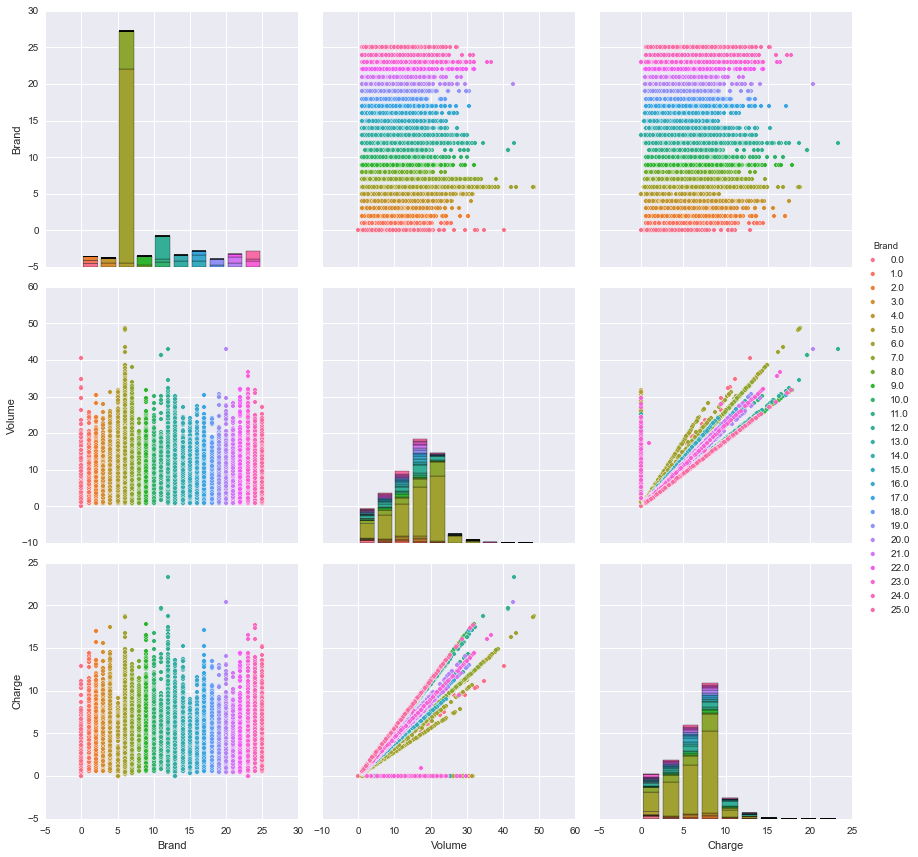

In [42]:
sns.pairplot(dfBrand, hue="Brand", size=4);

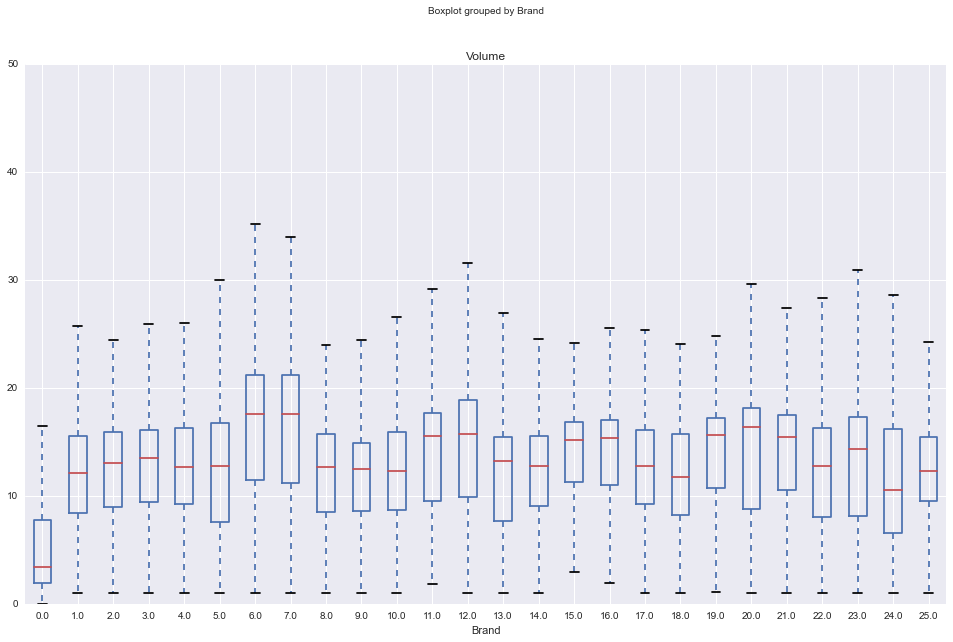

In [293]:
df.boxplot(column='Volume', by='Brand', figsize=(16,10));

### Inspecting date ranges

In [359]:
dfDateSort = df.sort(['Time'], ascending=[1])

In [360]:
dfDateSort['Date'].unique()

array(['28/03/15', '30/03/15', '31/03/15', '01/04/15', '03/04/15',
       '04/04/15', '05/04/15', '06/04/15', '07/04/15', '08/04/15',
       '09/04/15', '10/04/15', '11/04/15', '12/04/15', '13/04/15',
       '14/04/15', '15/04/15', '16/04/15', '17/04/15', '18/04/15',
       '19/04/15', '20/04/15', '21/04/15', '22/04/15', '24/04/15',
       '25/04/15', '26/04/15'], dtype=object)

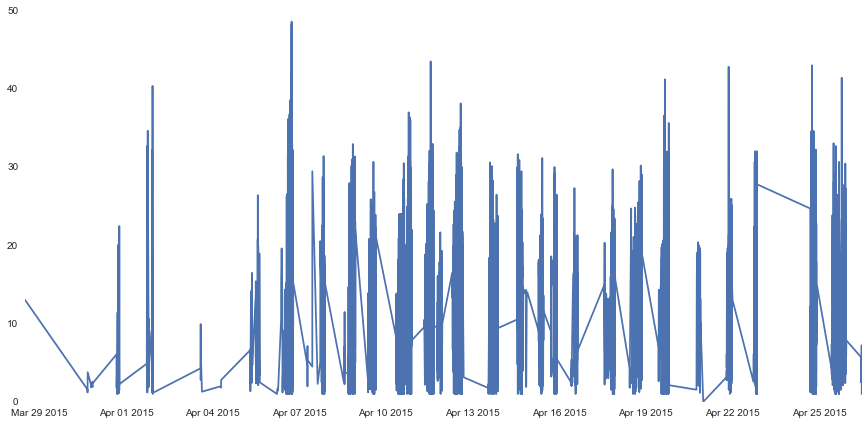

In [361]:
fig1, ax1 = plt.subplots(figsize=(15,7))
ax1.plot(dfDateSort['Time'], dfDateSort['Volume']);

In [362]:
dfApr7 = df[df['Date'] == "07/04/15"]

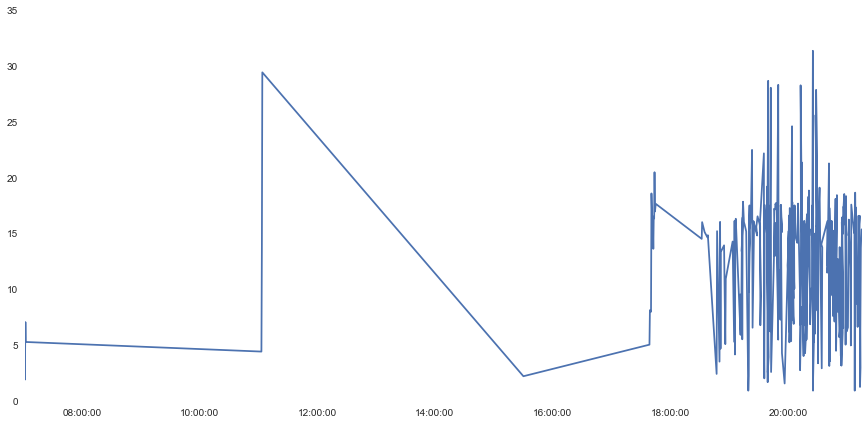

In [363]:
fig1, ax1 = plt.subplots(figsize=(15,7))
ax1.plot(dfApr7['Time'], dfApr7['Volume']);

In [364]:
dfApr7 = dfApr7.ix[18454:]

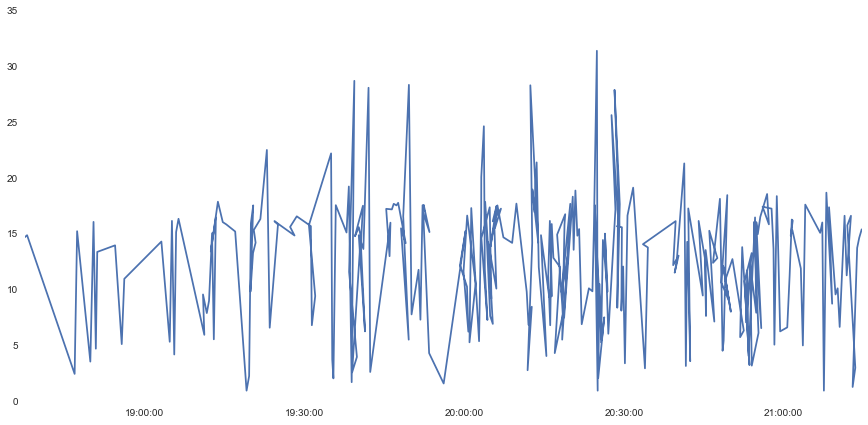

In [365]:
fig1, ax1 = plt.subplots(figsize=(15,7))
ax1.plot(dfApr7['Time'], dfApr7['Volume']);

In [50]:
dfApr7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284 entries, 18454 to 18737
Data columns (total 25 columns):
AI                     284 non-null int64
Date                   284 non-null object
Time                   284 non-null object
TapNumber              284 non-null int64
SKU                    284 non-null float64
Product                284 non-null object
Volume                 284 non-null float64
Charge                 284 non-null float64
PricePerViolCharged    284 non-null float64
PricePerVolume         284 non-null float64
HHPricePerVolume       284 non-null float64
CardNumber             284 non-null int64
CardType               284 non-null object
CardStatus             78 non-null object
OriginGroup            284 non-null object
OriginUnit             284 non-null object
SerialNumber           284 non-null object
SoftwareVersion        284 non-null float64
SystemRole             284 non-null object
Mode                   284 non-null object
Name                   77 

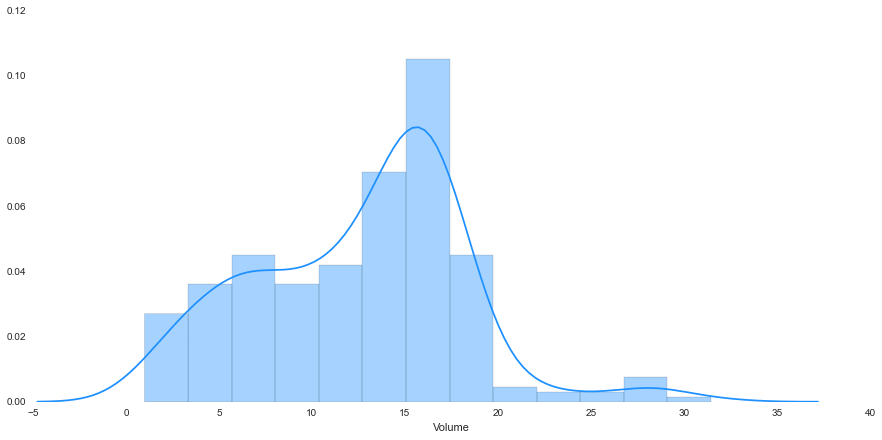

In [366]:
fig1, ax1 = plt.subplots(figsize=(15,7))
sns.distplot(dfApr7['Volume'], color="dodgerblue");

In [367]:
dfApr7.CardType.unique() 

array(['Pre Paid Currency', 'Staff'], dtype=object)

In [368]:
dfApr7.CardType.describe()

count                   284
unique                    2
top       Pre Paid Currency
freq                    206
dtype: object

## Predicting barrel changes

In [402]:
dfApr6 = df[df['Date'] == "06/04/15"]

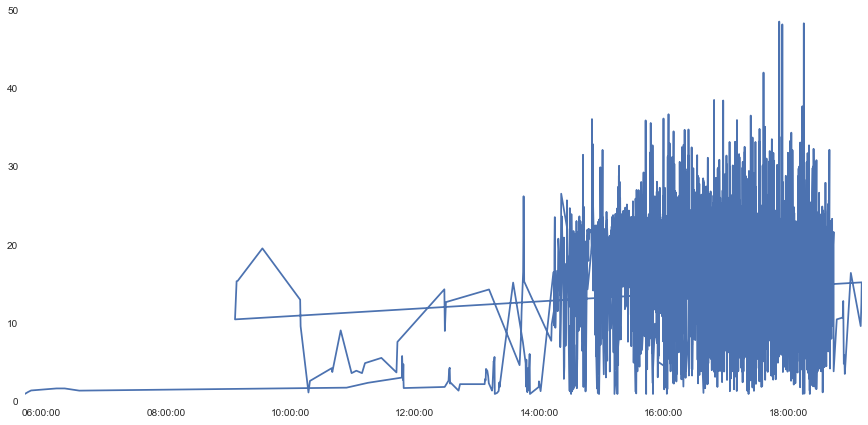

In [565]:
fig1, ax1 = plt.subplots(figsize=(15,7))
ax1.plot(dfApr6['Time'], dfApr6['Volume']);

To be continued if time permits...

This is the highest volume day and so probably the most number of barrel changes.  I want to see if I can pinpoint when they happen and the impact that a change has on revenue intake. 

## Analysing user behaviour

### Inspecting a specific user

As a first step in analysing user behaviour we can look at one specific user.

In [369]:
table(df1.loc[df1['CardNumber'] == 60233])

,Date,Time,TapNumber,Brand,Volume,Charge,PricePerVolume,VolumeRemain,PrePaidRemain,CardNumber,CardType,OriginGroup,OriginUnit,Product
1126,15/04/15,2015-04-15 21:56:24,1,19,1.71,0.73,0.43,30.29,14.27,60233,Pre Paid Currency,ab.onpremise,twins02.l,Shock Top
1127,15/04/15,2015-04-15 21:56:50,2,16,1.05,0.45,0.43,29.24,13.82,60233,Pre Paid Currency,ab.onpremise,twins03.l,Nordeast Grain Belt
1131,15/04/15,2015-04-15 21:57:21,2,15,17.81,6.68,0.38,11.43,7.14,60233,Pre Paid Currency,ab.onpremise,twins02.r,Michelob Golden
1134,15/04/15,2015-04-15 21:57:42,2,15,11.48,4.30,0.38,0.00,2.84,60233,Pre Paid Currency,ab.onpremise,twins02.r,Michelob Golden


The above shows us that:

* The user first tried a small amount of beers 19 and 16
* He/she then opted to pour two pints of beer 15, using up all of the money on that card

### Staff cards vs Pre Paid Currency

There are two types of card: Staff and Pre Paid Currency

In [55]:
dfStaff = df1.loc[df1['CardType'] == "Staff"]
print "There are " + str(len(dfStaff)) + " staff card entries"

There are 3123 staff card entries


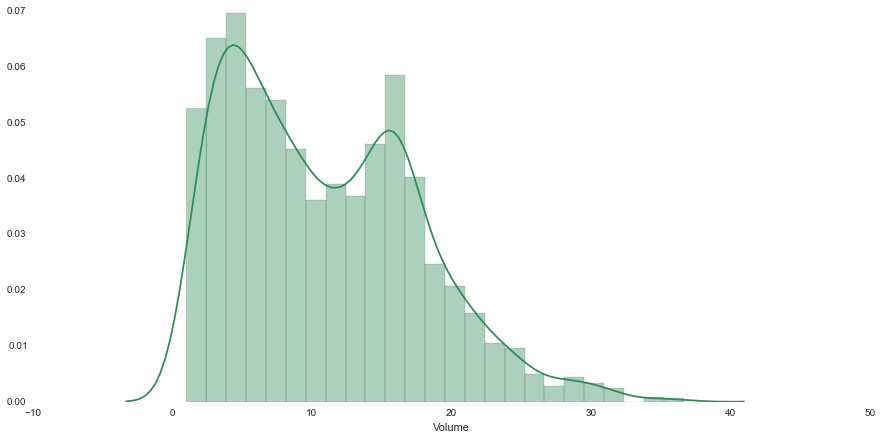

In [558]:
fig1, ax1 = plt.subplots(figsize=(15,7))
sns.distplot(dfStaff['Volume'], color="seagreen");

We can see that there are a lot of low volume pours that staff cards make.  My assumption is that this is for demonstration and marketing purposes

In [57]:
dfPrePaid = df1.loc[df1['CardType'] == "Pre Paid Currency"]
print "There are " + str(len(dfPrePaid)) + " Pre Paid Currency card entries"

There are 22060 Pre Paid Currency card entries


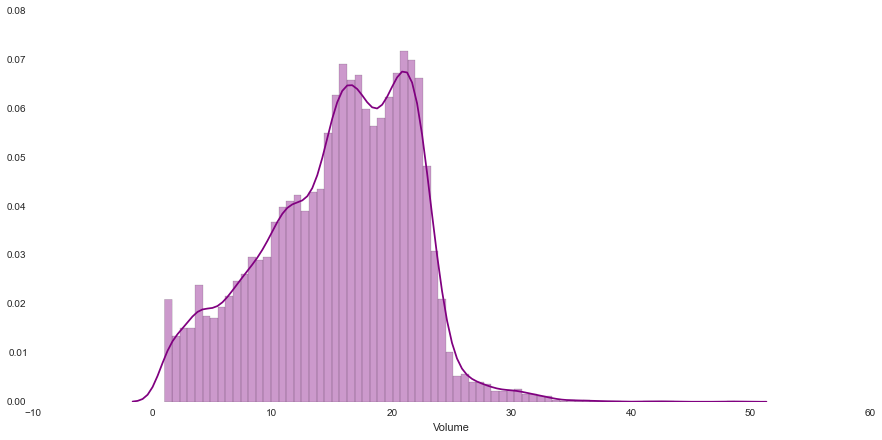

In [560]:
fig1, ax1 = plt.subplots(figsize=(15,7))
sns.distplot(dfPrePaid['Volume'], color="purple");

We can see that Pre Paid Currency cards tend to pour larger volume cups more regularly than staff cards

In [59]:
dfnan = df.loc[df['CardType'] != "Pre Paid Currency"]
dfnan = dfnan.loc[df['CardType'] != "Staff"]
print "There are " + str(len(dfnan)) + " empty card entries"

There are 259 empty card entries


It is unclear who these card users are and so when running user analysis we will focus on Pre Paid Currency cards

### Analysing "pre paid currency" users

In [370]:
table(dfPrePaid.ix[sample(dfPrePaid.index,5)])

,Date,Time,TapNumber,Brand,Volume,Charge,PricePerVolume,VolumeRemain,PrePaidRemain,CardNumber,CardType,OriginGroup,OriginUnit,Product
425,13/04/15,2015-04-13 16:41:24,2,16,17.79,7.56,0.43,14.21,7.44,59650,Pre Paid Currency,ab.onpremise,twins03.l,Nordeast Grain Belt
13434,12/04/15,2015-04-12 13:59:21,1,6,22.90,8.83,0.39,25.10,11.17,54714,Pre Paid Currency,ab.onpremise,reds05.l,Bud Light
11030,11/04/15,2015-04-11 13:27:31,1,6,23.55,9.08,0.39,24.45,10.92,52286,Pre Paid Currency,ab.onpremise,reds16.r,Bud Light
6370,06/04/15,2015-04-06 18:37:31,1,6,18.60,7.17,0.39,29.40,12.83,51291,Pre Paid Currency,ab.onpremise,reds08.l,Bud Light
2040,18/04/15,2015-04-18 15:23:55,2,6,13.33,5.00,0.38,18.67,10.00,59214,Pre Paid Currency,ab.onpremise,twins01.l,Bud Light


In [61]:
grouped = dfPrePaid.groupby('Brand').mean()
grouped = grouped.reset_index()
table(grouped)

,Brand,TapNumber,Volume,Charge,PricePerVolume,VolumeRemain,PrePaidRemain,CardNumber
0,1,1.000000,11.126646,6.230621,0.560000,43.214410,9.368509,59512.285714
1,2,1.000000,12.557708,7.032604,0.560000,41.334219,11.952500,58816.343750
2,3,1.000000,12.384306,6.935231,0.560000,41.322593,10.830833,59939.699074
3,4,1.000000,11.616579,6.504737,0.560000,42.031466,9.555489,60505.684211
4,5,2.000000,12.643103,5.694138,0.450460,16.155402,5.251839,40933.770115
5,6,1.214647,16.654432,6.397507,0.388002,25.500619,7.534513,51548.207142
6,7,2.000000,16.627501,6.427578,0.391351,26.680208,7.148730,52243.487993
7,8,1.000000,12.352857,6.917619,0.560000,42.005317,12.076032,61522.103175
8,9,1.000000,11.647022,6.522322,0.560000,44.015765,12.245628,59750.653005
9,10,2.000000,11.566654,6.477192,0.560000,45.201269,11.232038,62622.730769


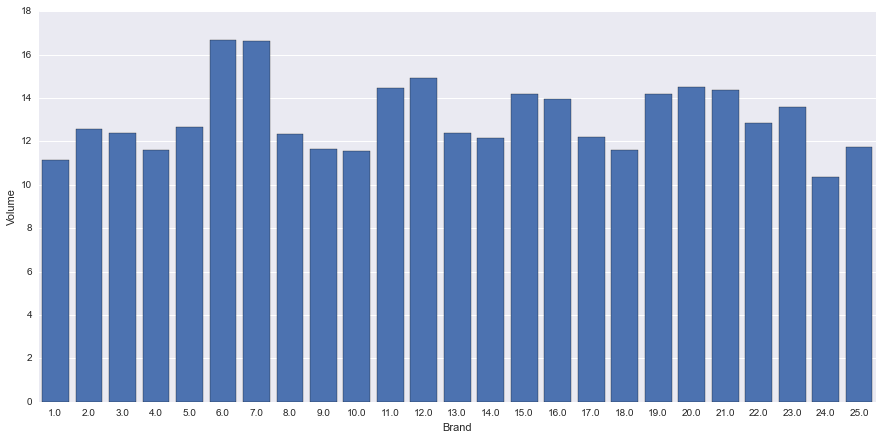

In [62]:
fig1, ax1 = plt.subplots(figsize=(15,7))
sns.barplot('Brand', 'Volume', data=grouped);

We can see from the above that the average pour varies by beer for paying users.

### Sort by users

In [63]:
dfUserSort = dfPrePaid.sort(['CardNumber'], ascending=[1])

### Looking at the relationship between card balance and volume poured

In [64]:
dfUserSort["BalancePrePour"] = 0.0

for x, row in dfUserSort.iterrows():
    dfUserSort["BalancePrePour"].ix[x] = dfUserSort["PrePaidRemain"].ix[x] + dfUserSort["Charge"].ix[x]

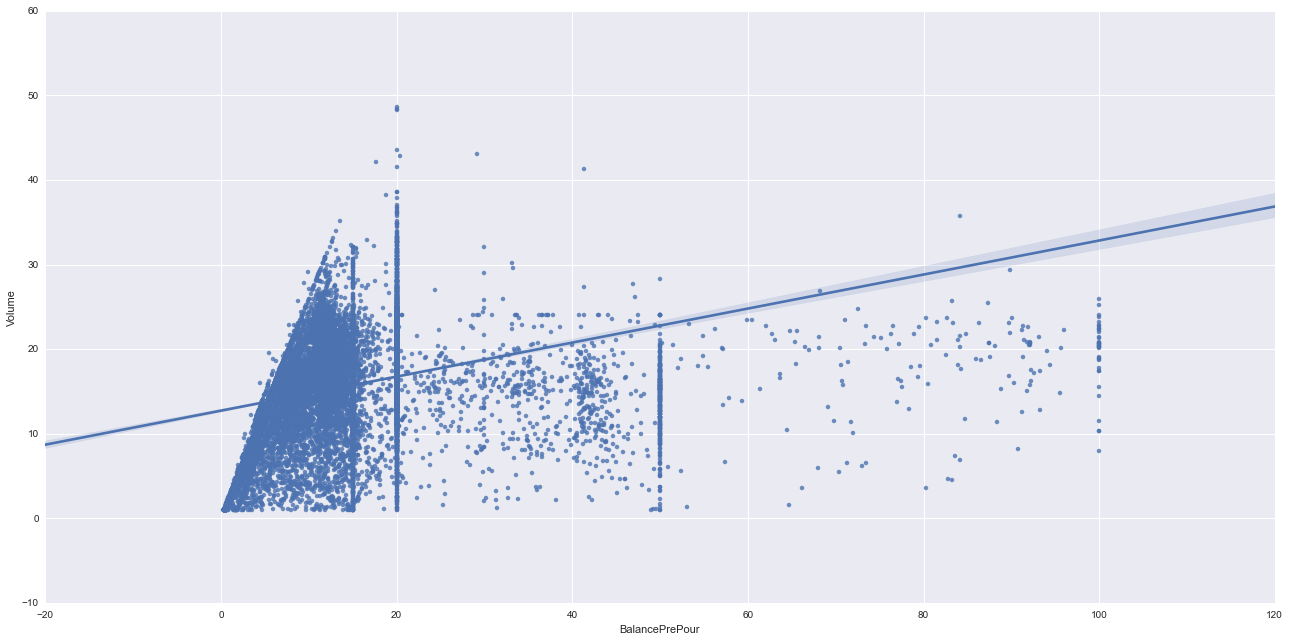

In [65]:
sns.lmplot('BalancePrePour', 'Volume', dfUserSort, size=9, aspect=2);

There appears to be some kind of relationship between card balance and the volume poured.  Specifically:

*  There appear to be three different card values, illustrated by the three straight lines at 15, 20 and 50 dollars
*  There is clearly a direct relationship at the lower end of the balance, whereby users can only pour a certain volume when their balance is at a certain level

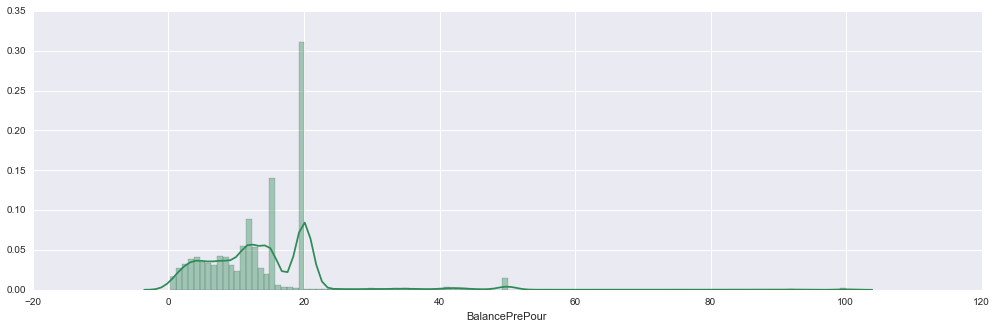

In [68]:
fig1, ax1 = plt.subplots(figsize=(17,5))
sns.distplot(dfUserSort['BalancePrePour'], color="seagreen");

The above histogram supports the hypothesis that there are three different card values

## Adding in external data

### Understanding the context of each machine

#### Business Group

Firstly we can look at the business groups that own the machines:

In [71]:
dfUserSort.OriginGroup.unique()

array(['DNC', 'philips.arena', 'ab.naz', 'ab.onpremise'], dtype=object)

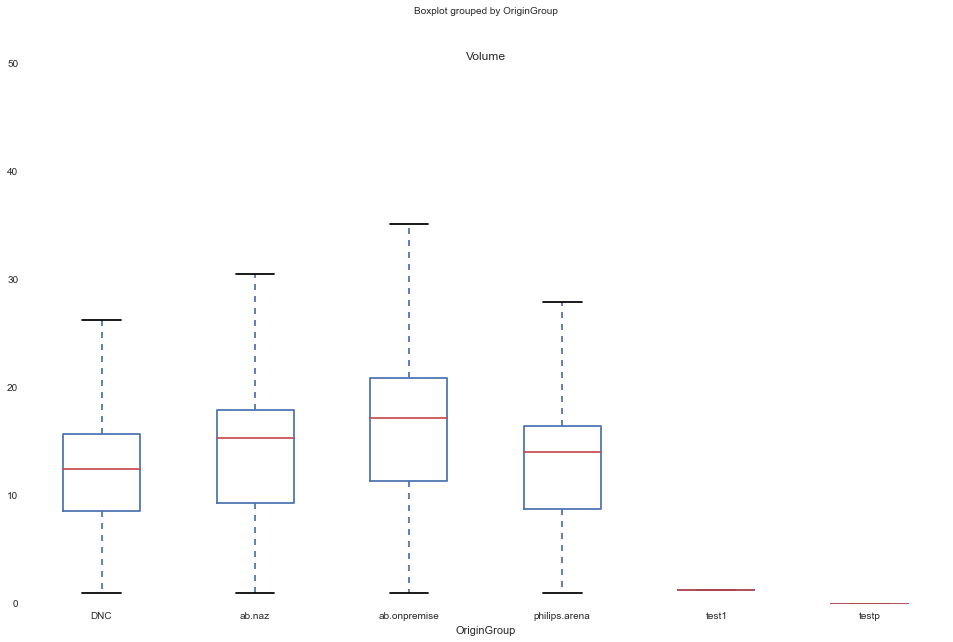

In [341]:
df.boxplot(column='Volume', by='OriginGroup', figsize=(16,10));

#### Location of machines

Next we can look at where each machine unit is placed by these groups:

In [72]:
dfPhilips = dfUserSort.loc[dfUserSort['OriginGroup'] == "philips.arena"]
dfPhilips.OriginUnit.unique()

array(['philips03.r', 'philips01.l', 'philips02.r', 'philips03.l',
       'philips02.l', 'philips01.r'], dtype=object)

In [73]:
dfDNC = dfUserSort.loc[dfUserSort['OriginGroup'] == "DNC"]
dfDNC.OriginUnit.unique()

array(['Indians01', 'Indians03', 'Indians04', 'Indians02', 'Indians05',
       'Indians06'], dtype=object)

In [74]:
dfabonpremise = dfUserSort.loc[dfUserSort['OriginGroup'] == "ab.onpremise"]
dfabonpremise.OriginUnit.unique()

array(['reds01.l', 'reds09.l', 'reds09.r', 'reds07.l', 'reds16.r',
       'reds01.r', 'reds07.r', 'reds17.l', 'reds13.l', 'reds02.r',
       'reds17.r', 'reds03.r', 'reds05.l', 'reds04.r', 'reds18.r',
       'reds15.r', 'reds14.l', 'reds12.r', 'reds15.l', 'reds12.l',
       'reds03.l', 'reds05.r', 'reds13.r', 'reds10.l', 'reds06.l',
       'reds19.r', 'reds06.r', 'reds11.r', 'reds02.l', 'reds16.l',
       'reds20.r', 'reds20.l', 'reds18.l', 'reds11.l', 'reds04.l',
       'reds19.l', 'reds14.r', 'reds10.r', 'reds08.r', 'reds08.l',
       'twins01.r', 'twins03.l', 'twins02.l', 'twins02.r', 'twins01.l',
       'twins03.r'], dtype=object)

From the above we can see that:

* Philips and DNC has one location
* AB has two locations

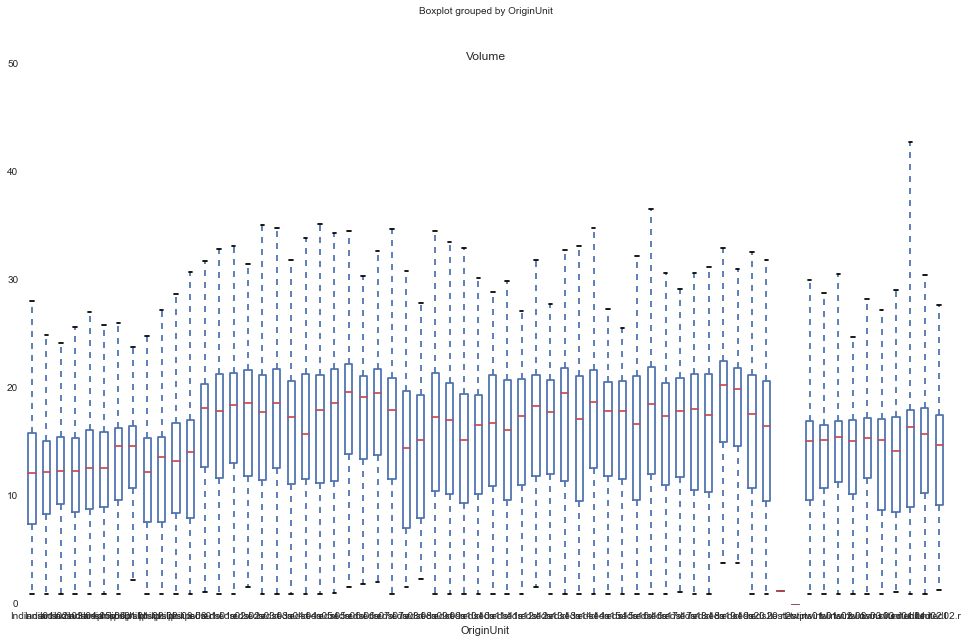

In [342]:
df.boxplot(column='Volume', by='OriginUnit', figsize=(16,10));

#### Dates machines are used

In [75]:
print dfPhilips.Date.unique()

['13/04/15' '19/04/15' '07/04/15' '22/04/15' '10/04/15' '11/04/15']


In [76]:
dfIndians01 = dfUserSort.loc[dfUserSort['OriginUnit'] == "Indians01"]
print dfIndians01.Date.unique()

['10/04/15' '06/04/15' '11/04/15' '15/04/15' '12/04/15' '14/04/15']


In [77]:
dfreds01 = dfUserSort.loc[dfUserSort['OriginUnit'] == "reds01.l"]
print dfreds01.Date.unique()

['06/04/15' '12/04/15' '25/04/15' '11/04/15' '10/04/15' '24/04/15'
 '08/04/15' '09/04/15']


In [78]:
dftwins01 = dfUserSort.loc[dfUserSort['OriginUnit'] == "twins01.r"]
print dftwins01.Date.unique()

['18/04/15' '17/04/15' '19/04/15' '13/04/15' '15/04/15' '16/04/15']


### Game results for each stadium on each day

A bit of research tells us that at each stadium the following results were recorded in April:

* Hawks:
    * Win - 7th
    * Win - 10th
    * Loss - 13th
    * Win - 19th
    * Win - 22nd
    * 11th was a comedy show

* Cincinnati Reds:
    * Win - 6th
    * Win - 8th
    * Win - 9th
    * Win - 10th
    * Loss - 11th
    * Loss - 12th
    * 13th - Playing away, but machines still in use
    * 15th - Playing away, but machines still in use
    * 16th - Playing away, but machines still in use
    * 17th - Playing away, but machines still in use
    * 18th - Playing away, but machines still in use
    * 19th - Playing away, but machines still in use
    * Loss - 24th
    * Rain stops play - 25th

* Twins:
    * Loss - 13th
    * Win - 15th
    * Win - 16th
    * Win - 17th
    * Loss - 18th
    * Win - 19th

* Indians:
    * 6th - Playing away
    * Loss - 10th 
    * Loss - 11th 
    * Loss - 12th 
    * Loss - 14th 
    * Win - 15th 

It is interesting to note that the machines in the Reds stadium were being used when the Reds were playing away.  Clearly fans are able to watch the game from the stadium, but we would expect quite different volumes consumed in total.

### Map game results to machines

In [79]:
dfUserSort['Team'] = "NA"

for x, row in dfUserSort.iterrows():
    if dfUserSort["OriginGroup"].ix[x] == "DNC":
        dfUserSort["Team"].ix[x] = "Indians"
    elif dfUserSort["OriginGroup"].ix[x] == "philips.arena":
        dfUserSort["Team"].ix[x] = "Hawks"
    elif dfUserSort["OriginGroup"].ix[x] == "ab.onpremise":
        if dfUserSort["OriginUnit"].ix[x] == 'twins01.r' or dfUserSort["OriginUnit"].ix[x] == 'twins03.l' or \
        dfUserSort["OriginUnit"].ix[x] == 'twins02.l' or dfUserSort["OriginUnit"].ix[x] == 'twins02.r' or \
        dfUserSort["OriginUnit"].ix[x] == 'twins01.l' or dfUserSort["OriginUnit"].ix[x] == 'twins03.r':
            dfUserSort["Team"].ix[x] = "Twins"
        else:
            dfUserSort["Team"].ix[x] = "Reds"

In [80]:
print len(dfUserSort.loc[dfUserSort['Team'] == 'Reds'])
print len(dfUserSort.loc[dfUserSort['Team'] == 'Indians'])
print len(dfUserSort.loc[dfUserSort['Team'] == 'Hawks'])
print len(dfUserSort.loc[dfUserSort['Team'] == 'Twins'])

14748
2878
1418
2119


In [81]:
def setwins(df):
    df['Result'] = "NA"
    for x, row in df.iterrows():
        if df["Team"].ix[x] == "Indians":
            if df["Date"].ix[x] == "15/04/15":
                df['Result'].ix[x] = "Win"
            elif df["Date"].ix[x] == "06/04/15":
                df['Result'].ix[x] = "NA"
            else:
                df['Result'].ix[x] = "Loss"
        if df["Team"].ix[x] == "Twins":
            if df["Date"].ix[x] == "13/04/15" or df["Date"].ix[x] == "18/04/15":
                df['Result'].ix[x] = "Loss"
            else:
                df['Result'].ix[x] = "Win"
        if df["Team"].ix[x] == "Reds":
            if df["Date"].ix[x] == "11/04/15" or df["Date"].ix[x] == "12/04/15" or df["Date"].ix[x] == "24/04/15":
                df['Result'].ix[x] = "Loss"
            elif df["Date"].ix[x] == "06/04/15" or df["Date"].ix[x] == "08/04/15" or \
                df["Date"].ix[x] == "09/04/15" or df["Date"].ix[x] == "10/04/15":
                df['Result'].ix[x] = "Win"
            else:
                df['Result'].ix[x] = "NA"
        if df["Team"].ix[x] == "Hawks":
            if df["Date"].ix[x] == "13/04/15":
                df['Result'].ix[x] = "Loss"
            elif df["Date"].ix[x] == "11/04/15":
                df['Result'].ix[x] = "NA"
            else:
                df['Result'].ix[x] = "Win"

setwins(dfUserSort)

### Calculate total beer volume drunk per venue per date

In [82]:
dfgames = dfUserSort.loc[dfUserSort['Result'] != "NA"]
dfGamesGrouped = dfgames.groupby(['Date', 'Team']).sum()
dfGamesGrouped = dfGamesGrouped.reset_index().sort(['Team', 'Volume'], ascending=[1, 0])
setwins(dfGamesGrouped)
dfGamesGrouped['TeamDate'] = "NA"
for x in range(0, len(dfGamesGrouped)):
    dfGamesGrouped['TeamDate'].ix[x] = dfGamesGrouped.Team.ix[x][:1] + "-" + dfGamesGrouped.Date.ix[x][:2]

In [83]:
table(dfGamesGrouped)

,Date,Team,TapNumber,Brand,Volume,Charge,PricePerVolume,VolumeRemain,PrePaidRemain,CardNumber,BalancePrePour,Result,TeamDate
21,22/04/15,Hawks,462,4629,5017.63,2045.16,149.73,5276.10,2110.10,15873235,4155.26,Win,H-22
19,19/04/15,Hawks,480,4904,4961.75,2024.71,150.53,5725.20,1879.59,16713347,3904.30,Win,H-19
4,10/04/15,Hawks,351,3307,3225.36,1299.28,99.81,3577.35,1174.07,11749691,2473.35,Win,H-10
1,07/04/15,Hawks,289,2830,2764.41,1109.04,85.15,3288.51,1143.74,3268180,2252.78,Win,H-07
11,13/04/15,Hawks,231,1807,2096.83,827.41,65.78,2504.39,775.97,7603912,1603.38,Loss,H-13
5,10/04/15,Indians,1216,9473,10152.49,5685.24,474.88,36392.18,10103.45,47626108,15788.69,Loss,I-10
7,11/04/15,Indians,1265,9549,9956.82,5575.64,469.84,35597.94,9774.70,51932581,15350.34,Loss,I-11
9,12/04/15,Indians,898,7134,6822.10,3820.37,315.28,24921.66,6269.29,34967273,10089.66,Loss,I-12
13,14/04/15,Indians,451,3409,3141.46,1759.09,155.68,12598.92,2477.28,17425371,4236.37,Loss,I-14
14,15/04/15,Indians,389,2987,2771.36,1552.02,137.20,10888.18,2915.07,15014471,4467.09,Win,I-15


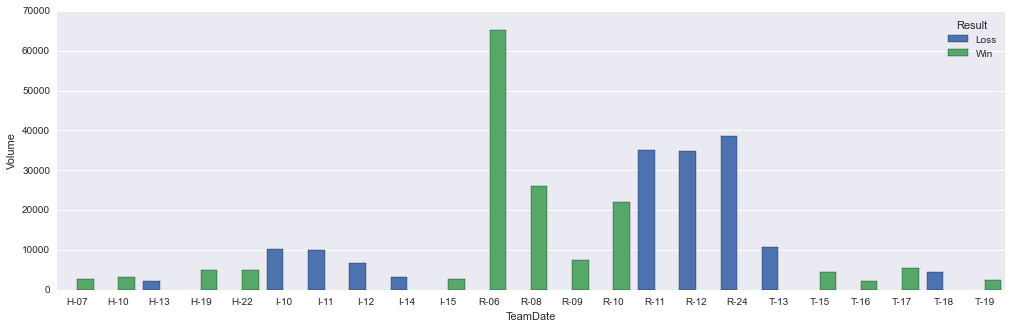

In [84]:
fig1, ax1 = plt.subplots(figsize=(17,5))
sns.barplot(dfGamesGrouped.TeamDate, y=dfGamesGrouped['Volume'], hue=dfGamesGrouped.Result);

We can see that there are large variations in total beer consumption between different dates, but these differences do not seem to be due to wins or losses.  A much better estimate might be game attendance.

### Game attendance

Each stadium reported the following attendance figures for April:

* Hawks:
    * 7th - 18,650
    * 10th - 18,462
    * 13th - 18,265
    * 19th - 18,440
    * 22nd - 18,207
    * 11th was a comedy show

* Cincinnati Reds:
    * 6th - 43,633
    * 8th - 30,859
    * 9th - 15,616
    * 10th - 30,808
    * 11th - 41,525
    * 12th - 41,446
    * 13th - Playing away, but machines still in use
    * 15th - Playing away, but machines still in use
    * 16th - Playing away, but machines still in use
    * 17th - Playing away, but machines still in use
    * 18th - Playing away, but machines still in use
    * 19th - Playing away, but machines still in use
    * 24th - 39,891
    * Rain stops play - 25th - 38,954

* Twins:
    * 13th - 40,123
    * 15th - 21,362
    * 16th - 17,449
    * 17th - 21,307
    * 18th - 23,949
    * 19th - 17,923

* Indians:
    * 6th - Playing away
    * 10th - 35,789 
    * 11th - 23,161 
    * 12th - 19,555 
    * 14th - 10,642 
    * 15th - 11,042 

### Map attendance to machines

In [85]:
def setAttendance(df):
    df['Attendance'] = 0
    for x, row in df.iterrows():
        if df["Team"].ix[x] == "Indians":
            if df["Date"].ix[x] == "10/04/15":
                df['Attendance'].ix[x] = 35789
            elif df["Date"].ix[x] == "11/04/15":
                df['Attendance'].ix[x] = 23161
            elif df["Date"].ix[x] == "12/04/15":
                df['Attendance'].ix[x] = 19555
            elif df["Date"].ix[x] == "14/04/15":
                df['Attendance'].ix[x] = 10642
            elif df["Date"].ix[x] == "15/04/15":
                df['Attendance'].ix[x] = 11042         
        if df["Team"].ix[x] == "Twins":
            if df["Date"].ix[x] == "13/04/15":
                df['Attendance'].ix[x] = 40123
            elif df["Date"].ix[x] == "15/04/15":
                df['Attendance'].ix[x] = 21362
            elif df["Date"].ix[x] == "16/04/15":
                df['Attendance'].ix[x] = 17449
            elif df["Date"].ix[x] == "17/04/15":
                df['Attendance'].ix[x] = 21307
            elif df["Date"].ix[x] == "18/04/15":
                df['Attendance'].ix[x] = 23949
            else:
                df['Attendance'].ix[x] = 17923 
        if df["Team"].ix[x] == "Reds":
            if df["Date"].ix[x] == "06/04/15":
                df['Attendance'].ix[x] = 43633
            elif df["Date"].ix[x] == "08/04/15":
                df['Attendance'].ix[x] = 30859
            elif df["Date"].ix[x] == "09/04/15":
                df['Attendance'].ix[x] = 15616
            elif df["Date"].ix[x] == "10/04/15":
                df['Attendance'].ix[x] = 30808
            elif df["Date"].ix[x] == "11/04/15":
                df['Attendance'].ix[x] = 41525
            elif df["Date"].ix[x] == "12/04/15":
                df['Attendance'].ix[x] = 41446
            elif df["Date"].ix[x] == "24/04/15":
                df['Attendance'].ix[x] = 39891
        if df["Team"].ix[x] == "Hawks":
            if df["Date"].ix[x] == "07/04/15":
                df['Attendance'].ix[x] = 18650
            elif df["Date"].ix[x] == "10/04/15":
                df['Attendance'].ix[x] = 18462
            elif df["Date"].ix[x] == "13/04/15":
                df['Attendance'].ix[x] = 18265
            elif df["Date"].ix[x] == "19/04/15":
                df['Attendance'].ix[x] = 18440
            elif df["Date"].ix[x] == "22/04/15":
                df['Attendance'].ix[x] = 18207

setAttendance(dfUserSort)

In [86]:
setAttendance(dfGamesGrouped)

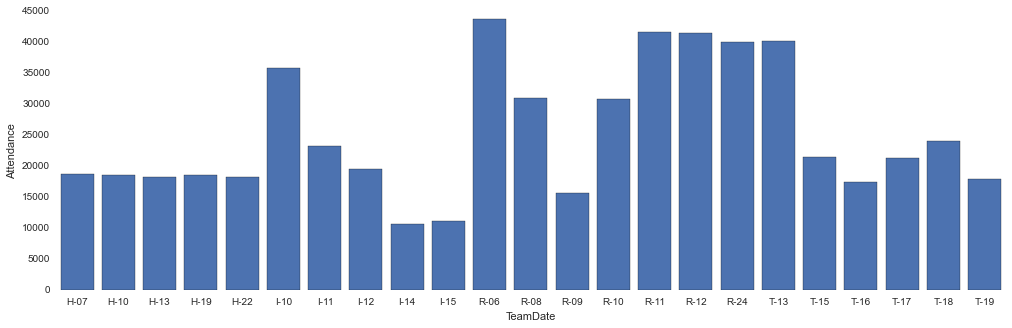

In [344]:
fig1, ax1 = plt.subplots(figsize=(17,5))
sns.barplot(dfGamesGrouped.TeamDate, y=dfGamesGrouped['Attendance']);

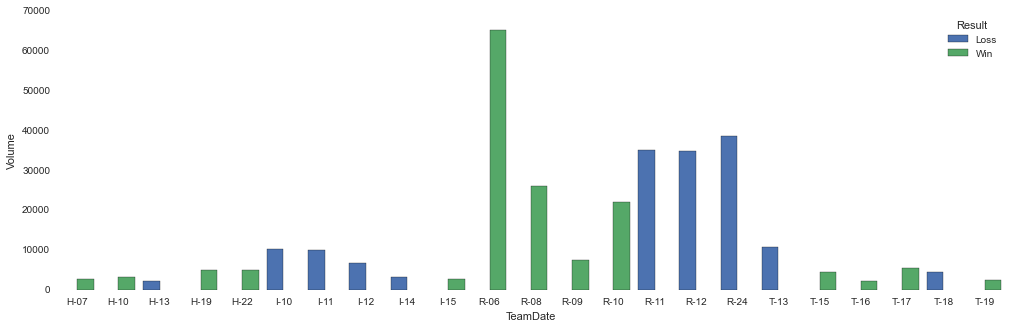

In [345]:
fig1, ax1 = plt.subplots(figsize=(17,5))
sns.barplot(dfGamesGrouped.TeamDate, y=dfGamesGrouped['Volume'], hue=dfGamesGrouped.Result);

By comparing the two graphs above, we can see that there appears to be a direct relationship between attendance and total volume of beer consumed at a venue.

### Create a simple linear model comparing total beer volume consumed and game attendance

In [522]:
def linearModel (feature1, feature2, feature1name, feature2name):
    # Make the model object
    regr = linear_model.LinearRegression()

    # Fit the data
    Attendance = [[x] for x in feature1.values]
    Volume = feature2.values

    regr.fit(Attendance, Volume)
    print "The regression coefficient is " + str(regr.coef_)
    print "The SSE is " + str(np.sum((regr.predict(feature1name) - feature2name) ** 2))
    # Scoring our model (closer to 1 is better!)
    print "The score is " + str(regr.score(feature1name, feature2name))

linearModel(dfGamesGrouped['Attendance'], dfGamesGrouped['Volume'], Attendance, Volume)

The regression coefficient is [ 1.27034978]
The SSE is 1884556823.52
The score is 0.672684583596


Our performance here is okay, but not great - we explained ~67% of the variance in the dataset, and can verify this with a plot:

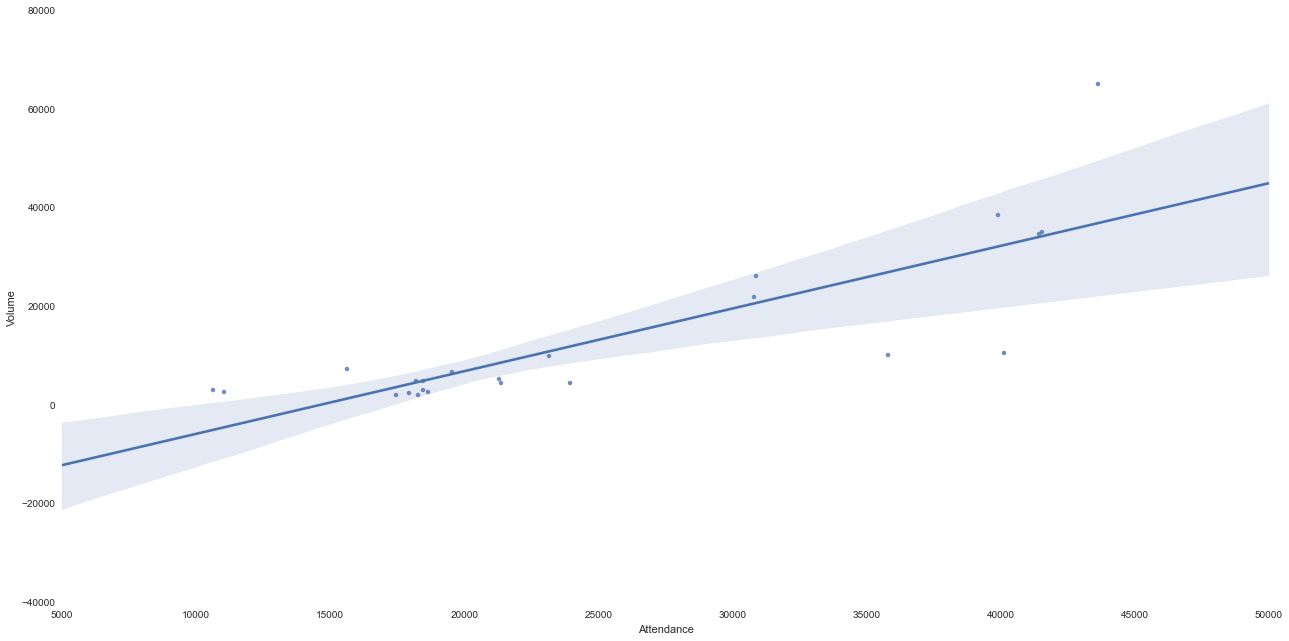

In [375]:
sns.lmplot('Attendance', 'Volume', dfGamesGrouped, size=9, aspect=2);

### Given the attendence, does winning or losing affect beer consumption volume?

In [523]:
dfWin = dfGamesGrouped.loc[dfGamesGrouped['Result'] == "Win"]
dfLoss = dfGamesGrouped.loc[dfGamesGrouped['Result'] == "Loss"]

In [524]:
linearModel(dfWin['Attendance'], dfWin['Volume'], Attendance, Volume)

The regression coefficient is [ 1.94503825]
The SSE is 3508375910.33
The score is 0.390654870335


In [525]:
linearModel(dfLoss['Attendance'], dfLoss['Volume'], Attendance, Volume)

The regression coefficient is [ 0.99128058]
The SSE is 2177538829.3
The score is 0.621798600205


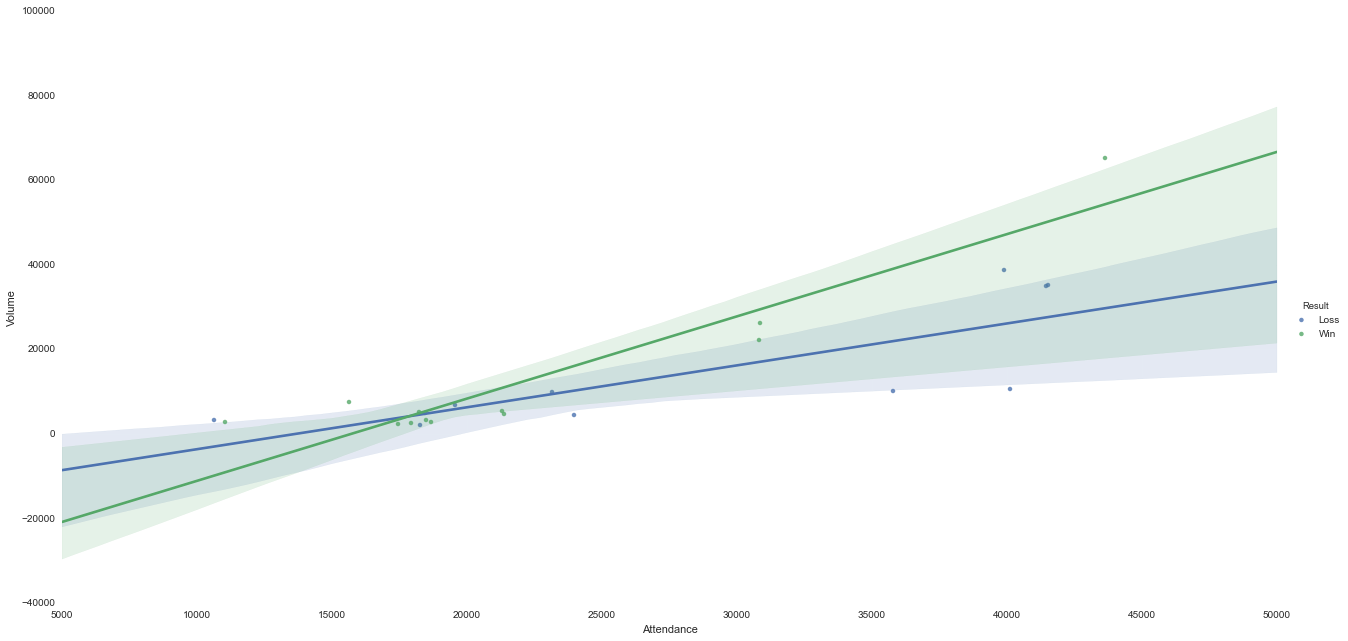

In [374]:
sns.lmplot('Attendance', 'Volume', dfGamesGrouped, hue="Result", size=9, aspect=2);

While the relationship is relatively weak, we can see that at losing home games the volume of beer drunk per head is lower than at winning home games

## Impact of tasting a beer on a users' subsequent pour

Firstly, let's have a look at the pour volume distribution of some different brands

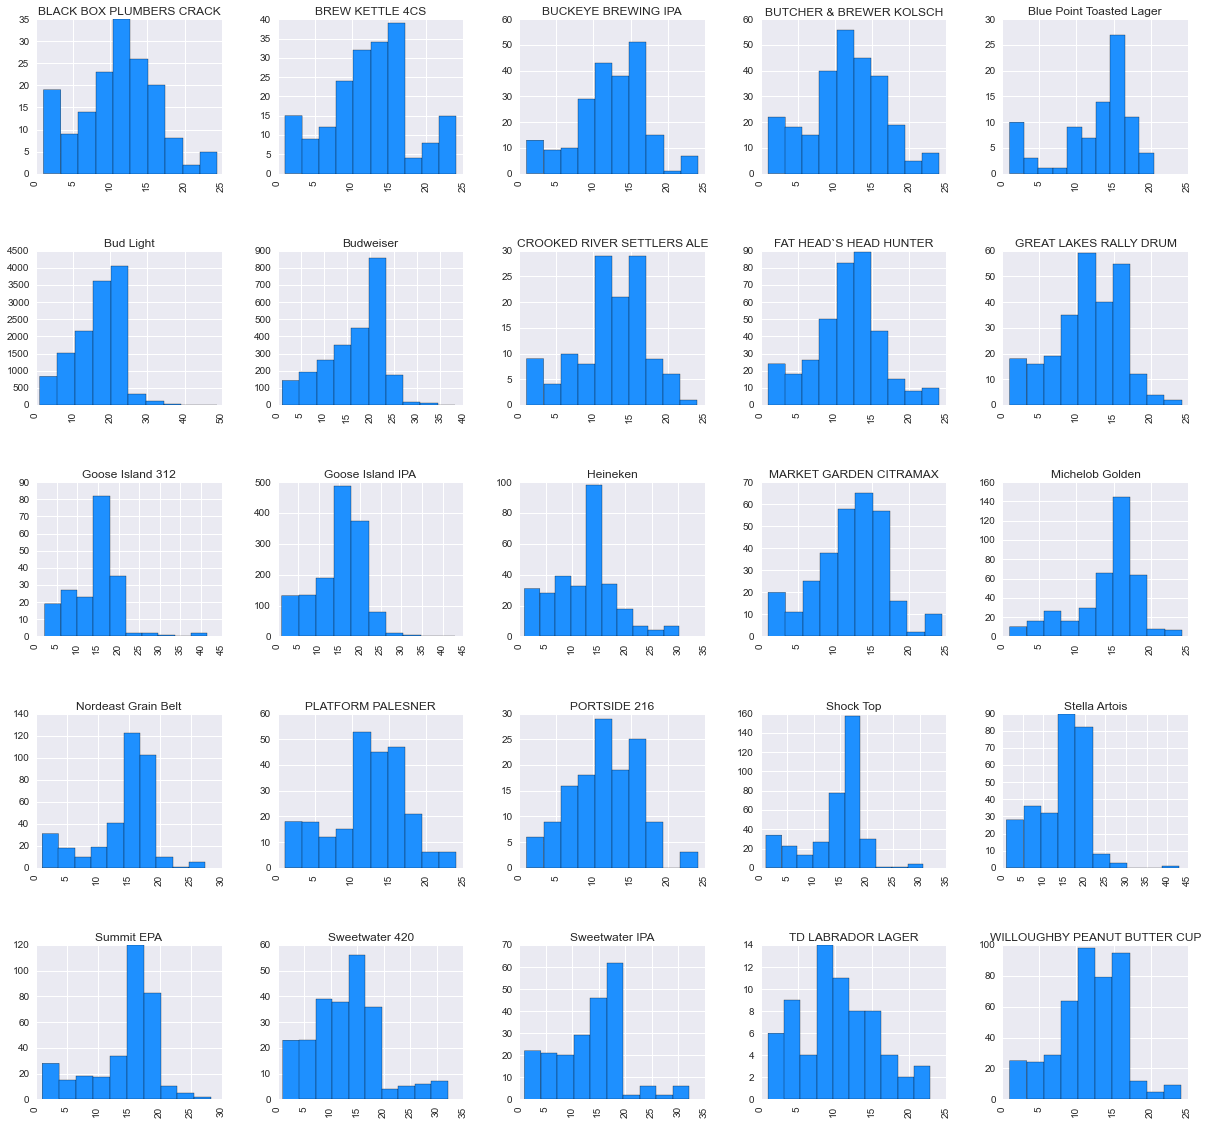

In [91]:
dfUserSort.hist('Volume', by=dfUserSort.Product, color='dodgerblue', figsize=(20, 20));

### Determining whether a user is tasting, pouring a pint or finishing their card balance

In [92]:
dfUserSort['Taster'] = 0
dfUserSort['FullDrink'] = 0
dfUserSort['Finisher'] = 0

for x, row in dfUserSort.iterrows():
    if dfUserSort["BalancePrePour"].ix[x] > 6:
        if dfUserSort["Volume"].ix[x] < 10:
            dfUserSort['Taster'].ix[x] = 1
        else:
            dfUserSort['FullDrink'].ix[x] = 1
    else:
        dfUserSort['Finisher'].ix[x] = 1

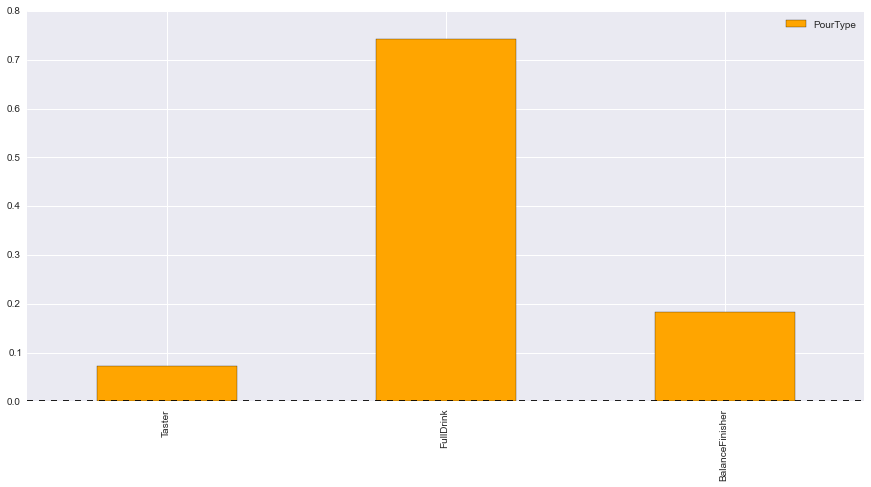

In [93]:
pourTypes = [dfUserSort.Taster.describe()['mean'], dfUserSort.FullDrink.describe()['mean'], dfUserSort.Finisher.describe()['mean']] 
dfPourType = pd.DataFrame(data = pourTypes)
dfPourType = dfPourType.rename(index={0: 'Taster', 1: 'FullDrink', 2:'BalanceFinisher'})
dfPourType.columns = ['PourType']
dfPourType.plot(kind='bar', figsize=(15,7), color='orange');

### Looking at how often different brands are "tasted"

In [94]:
groupedBrand = dfUserSort.groupby('Brand').mean()
groupedBrand = groupedBrand.reset_index()

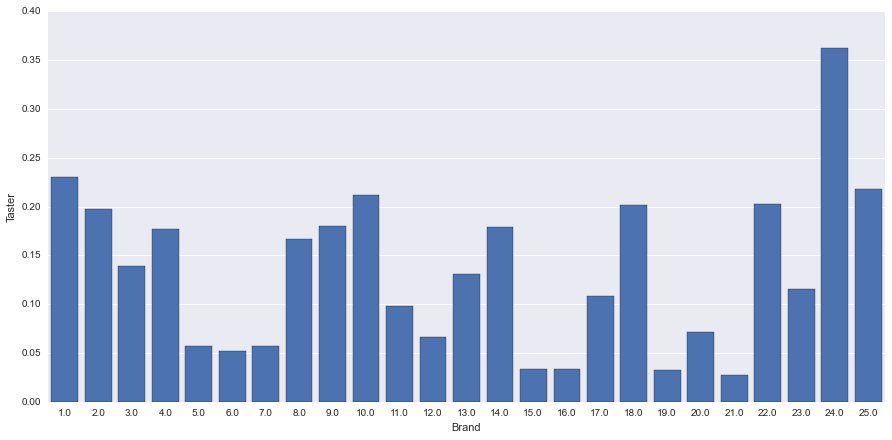

In [95]:
fig1, ax1 = plt.subplots(figsize=(15,7))
sns.barplot('Brand', 'Taster', data=groupedBrand);

### Predicting what the next pour will be: a taster, full drink or card finisher

We are now going to create a model that predicts whether a user will next pour a Taster, Full Pint or Balance Finisher.

#### Add column that states what the next drink will be

In [572]:
dfPredictPint = dfUserSort
dfPredictPint = dfPredictPint.reset_index(drop=True)

In [573]:
dfPredictPint['NextDrink'] = 0

for x, row in dfPredictPint.iterrows():
    try:
        if dfPredictPint.Taster[x+1] == 1 and dfPredictPint.CardNumber[x] == dfPredictPint.CardNumber[x+1]:
            dfPredictPint.NextDrink[x] = 1
        elif dfPredictPint.FullDrink[x+1] == 1 and dfPredictPint.CardNumber[x] == dfPredictPint.CardNumber[x+1]:
            dfPredictPint.NextDrink[x] = 2
        elif dfPredictPint.Finisher[x+1] == 1 and dfPredictPint.CardNumber[x] == dfPredictPint.CardNumber[x+1]:
            dfPredictPint.NextDrink[x] = 3
    except:
        dfPredictPint.NextDrink[x] = 3

In [574]:
table(dfPredictPint.head())

,Date,Time,TapNumber,Brand,Volume,Charge,PricePerVolume,VolumeRemain,PrePaidRemain,CardNumber,CardType,OriginGroup,OriginUnit,Product,BalancePrePour,Team,Result,Attendance,Taster,FullDrink,Finisher,NextDrink
0,10/04/15,2015-04-10 15:12:11,1,2,24.02,13.45,0.56,39.98,1.55,2402,Pre Paid Currency,DNC,Indians01,BREW KETTLE 4CS,15.00,Indians,Loss,35789,0,1,0,3
1,10/04/15,2015-04-10 15:12:30,1,2,2.81,1.57,0.56,37.17,0.00,2402,Pre Paid Currency,DNC,Indians01,BREW KETTLE 4CS,1.57,Indians,Loss,35789,0,0,1,0
2,10/04/15,2015-04-10 14:06:33,1,2,18.57,10.40,0.56,45.43,4.60,2408,Pre Paid Currency,DNC,Indians01,BREW KETTLE 4CS,15.00,Indians,Loss,35789,0,1,0,3
3,10/04/15,2015-04-10 14:07:34,1,2,8.26,4.63,0.56,37.17,0.00,2408,Pre Paid Currency,DNC,Indians01,BREW KETTLE 4CS,4.63,Indians,Loss,35789,0,0,1,0
4,10/04/15,2015-04-10 14:18:36,2,25,16.00,8.96,0.56,48.00,6.04,2409,Pre Paid Currency,DNC,Indians03,WILLOUGHBY PEANUT BUTTER CUP,15.00,Indians,Loss,35789,0,1,0,2


#### Remove redundant features

In [476]:
dfPredictPint = dfPredictPint[['Volume', 'PricePerVolume', 'PrePaidRemain', 'BalancePrePour', 'Brand', 'Taster', 'FullDrink', 'Finisher', 'NextDrink']]

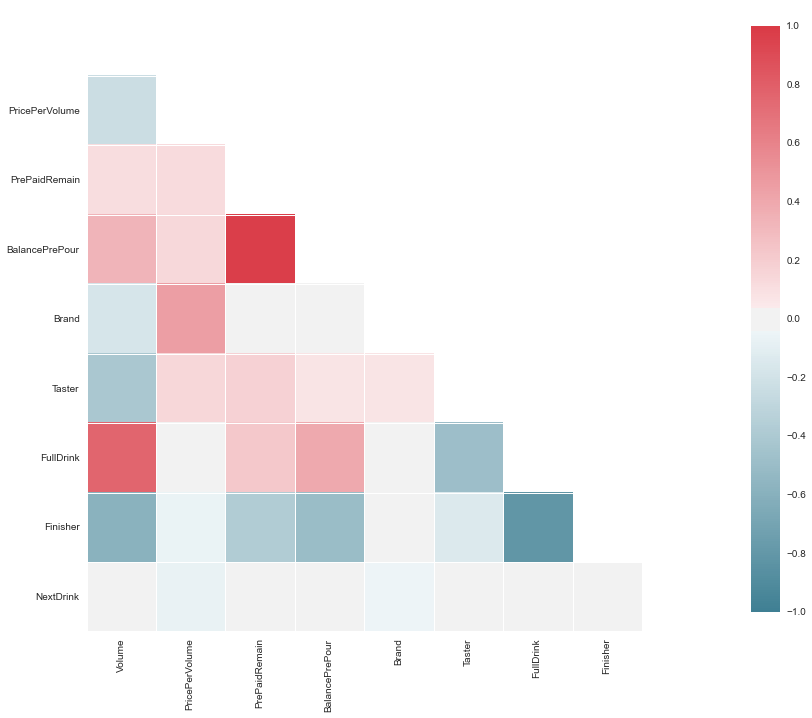

In [477]:
f, ax = plt.subplots(figsize=(14, 14))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.corrplot(dfPredictPint, annot=False, sig_stars=False,
             diag_names=False, cmap=cmap, ax=ax);

In [478]:
def findCorrelation(df,threshold=0.5):
    cor = df.corr()
    cor.loc[:,:] = np.tril(cor.values, k=-1)
    cor = cor.stack()
    return cor[cor > threshold]

In [479]:
findCorrelation(dfPredictPint, 0.8)

BalancePrePour  PrePaidRemain    0.970025
dtype: float64

In [480]:
dfPredictPint = dfPredictPint.drop('BalancePrePour', 1)

### Using logistic regression build a model to determine what the next user pour will be

In [501]:
from sklearn import linear_model

logm = linear_model.LogisticRegression()

X = dfUserSort[ ['Volume', 'PricePerVolume', 'PrePaidRemain', 'Brand', 'Taster', 'FullDrink', 'Finisher'] ].values
y = dfPredictPint['NextDrink'].values

In [502]:
logm.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [503]:
logm.score(X, y)

0.46187669990933816

The result is almost exactly random, meaning that this is an extremely poor model to use!

### Using KNN to determine what the next user pour will be

In [434]:
from matplotlib.colors import ListedColormap
from sklearn import feature_selection
from sklearn.neighbors import KNeighborsClassifier as KNN

In [487]:
X = dfPredictPint.iloc[:,0:7]
y = dfPredictPint.iloc[:,7]

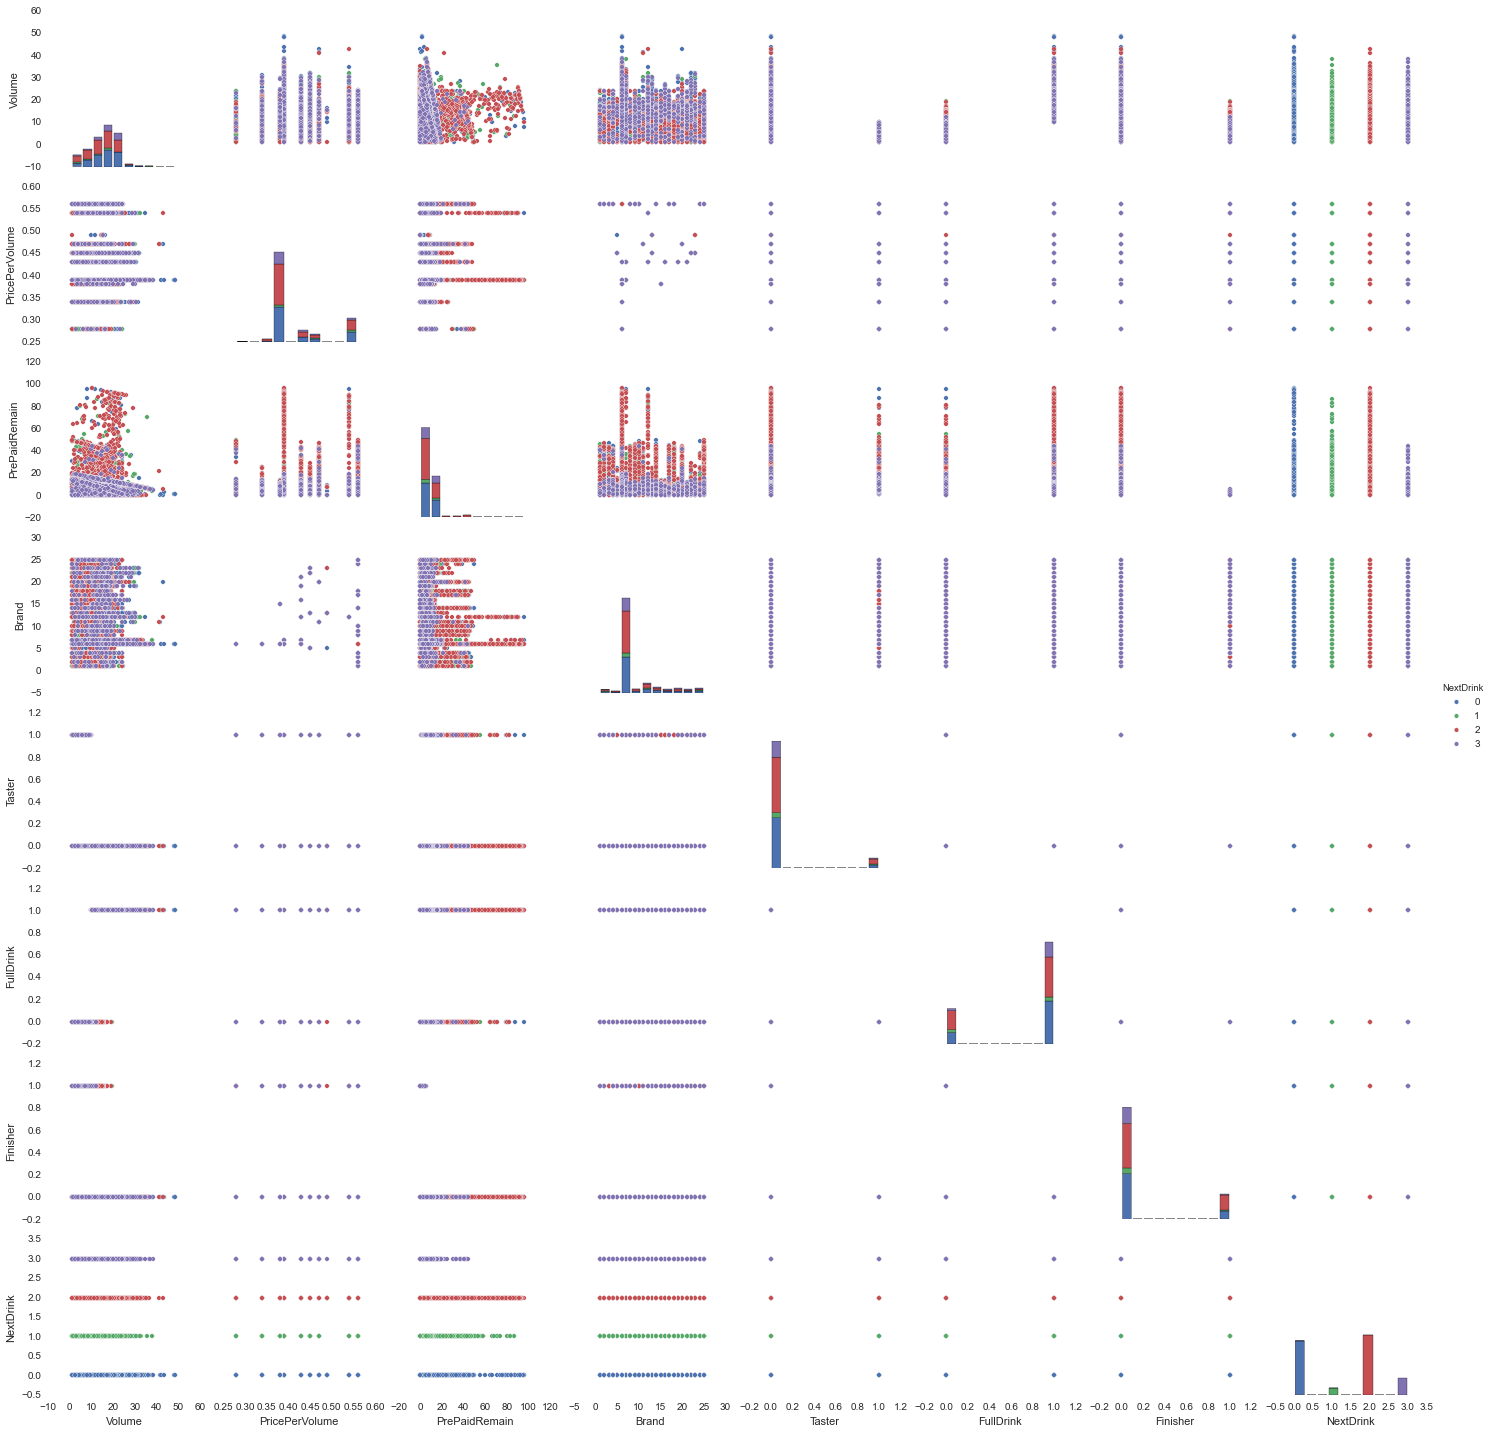

In [488]:
sns.pairplot(dfPredictPint, hue="NextDrink", size=2.5);

#### Splitting into Training / Test set

In [575]:
# Or by using the built-in method from SciKit-Learn
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                        test_size=0.30,
                                        random_state=10)

In [576]:
n_neighbors = range(1,51,1)

In [577]:
scores = []
for n in n_neighbors:
    clf = KNN(n)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

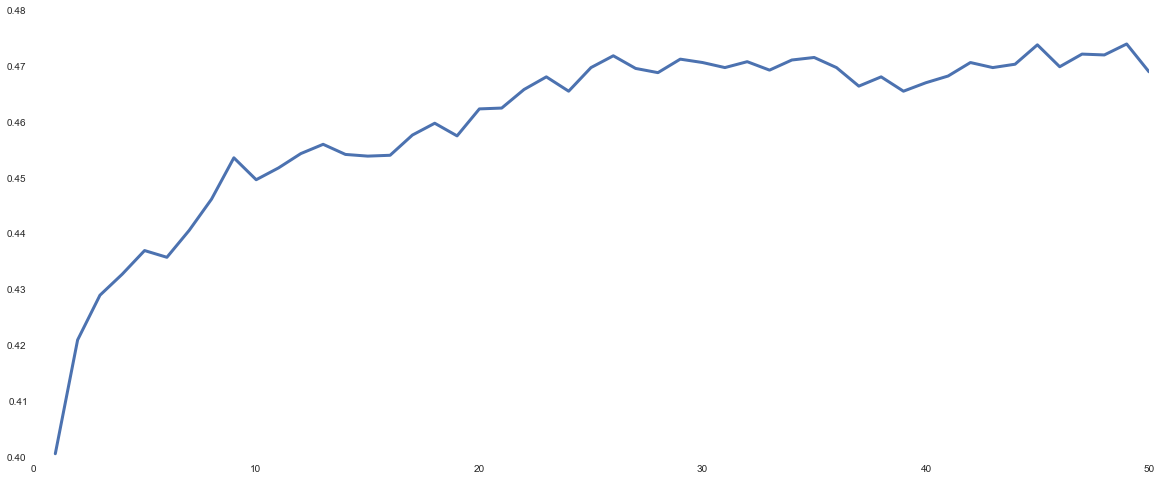

In [578]:
plt.figure(figsize=(20,8))
plt.plot(n_neighbors, scores, linewidth=3.0)
plt.show()

Not quite sure what I should read from this....  I'm guessing that this is massively overfitting the data?!

#### Application of cross validation

In [581]:
scores = []
idx = np.random.uniform(0, 1, len(X)) >= 0.3
for n in range(5):
    np.random.shuffle(idx)
    X_train, X_test = X[idx], X[idx == False]
    y_train, y_test = y[idx], y[idx == False]
    clf = KNN(30, weights='uniform')
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

In [582]:
scores 

[0.46846708608255333,
 0.45833972686819091,
 0.46769986189964707,
 0.46355685131195334,
 0.46539818935092836]

In [583]:
np.mean(scores)

0.46469234310265461

Again, we can see that the score is not strong, meaning that this is not a good model to use for this prediction.

### Using ensemble methods to determine what the next user pour will be

In [527]:
from sklearn.cross_validation import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

In [551]:
X = dfPredictPint.iloc[:,0:3]
y = dfPredictPint.iloc[:,7]

#### Normalise data

In [552]:
from sklearn import preprocessing
X_normalized = preprocessing.normalize(X, norm='l2')

#### Add back in categorical data

In [547]:
X_normalized = pd.DataFrame(X_normalized)

In [548]:
X_normalized['Taster'], X_normalized['FullDrink'], X_normalized['Finisher'] = dfPredictPint.Taster, dfPredictPint.FullDrink, dfPredictPint.Finisher       

In [549]:
X_normalized = pd.DataFrame.as_matrix(X_normalized)

#### Run decision tree, random forest and extra trees classifiers over the dataset

In [553]:
## DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=None, min_samples_split=1,
       random_state=0)
scores = cross_val_score(clf, X_normalized, y)
print "DecisionTreeClassifier:", scores.mean()

## RandomForestClassifier
clf = RandomForestClassifier(n_estimators=1, max_depth=None,
     min_samples_split=1, random_state=0)
scores = cross_val_score(clf, X_normalized, y)
print "RandomForestClassifier:", scores

## ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=1, max_depth=None,
    min_samples_split=1, random_state=0)
scores = cross_val_score(clf, X_normalized, y)
print "ExtraTreesClassifier:  ", scores

DecisionTreeClassifier: 0.385674473836
RandomForestClassifier: [ 0.39374575  0.39507684  0.37880849]
ExtraTreesClassifier:   [ 0.38653977  0.39793282  0.36575082]


Again, we can see that the scores are not convincing

### Feature Engineering

#### Split the data into features and classifiers

In [449]:
X = dfPredictPint.iloc[:,0:3]
y = dfPredictPint.iloc[:,7]

####Normalise the data

In [267]:
from sklearn import preprocessing
X_normalized = preprocessing.normalize(X, norm='l2')

#### Add binary data back in

In [268]:
X_normalized = pd.DataFrame(X_normalized)

In [269]:
X_normalized['Taster'], X_normalized['FullDrink'], X_normalized['Finisher'] = dfPredictPint.Taster, dfPredictPint.FullDrink, dfPredictPint.Finisher       

In [271]:
X_normalized = pd.DataFrame.as_matrix(X_normalized)

In [272]:
X_normalized

array([[ 0.99765448,  0.02325922,  0.0643782 ,  0.        ,  1.        ,
         0.        ],
       [ 0.98071468,  0.19544492,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.97024738,  0.02925894,  0.2403413 ,  0.        ,  1.        ,
         0.        ],
       ..., 
       [ 0.23937607,  0.01551512,  0.97080296,  1.        ,  0.        ,
         0.        ],
       [ 0.06901796,  0.01160662,  0.9975479 ,  1.        ,  0.        ,
         0.        ],
       [ 0.34665606,  0.01317011,  0.93789985,  0.        ,  1.        ,
         0.        ]])

#### Rank features by importance

Feature ranking:
1. feature Volume (0.352928)
2. feature PricePerVolume (0.338525)
3. feature PrePaidRemain (0.287254)
4. feature Taster (0.010596)
5. feature FullDrink (0.008379)
6. feature Finisher (0.002319)


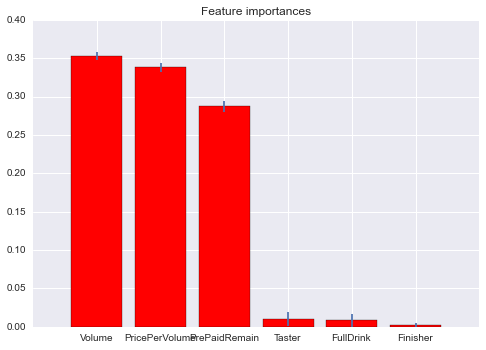

In [273]:
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X_normalized, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

x_labels = dfPredictPint.ix[:, [0, 1, 2, 3, 4, 5]].columns

# Print the feature ranking
print "Feature ranking:"

for f in xrange(6):
    print "%d. feature %s (%f)" % (f + 1, x_labels[f], importances[indices[f]])

# Plot the feature importances of the forest
import pylab as pl
pl.figure()
pl.title("Feature importances")
pl.bar(xrange(6), importances[indices],
       color="r", yerr=std[indices], align="center")

pl.xticks(xrange(6), x_labels)
pl.xlim([-1, 6])
pl.xticks
pl.show()

### Clustering

In [281]:
from sklearn.metrics import silhouette_score
from sklearn import cluster

In [285]:
for x in range(2, 10):
    cls = cluster.k_means(dfPredictPint, x)
    print "With " + str(x) + ' clusters the silhouette score is ' + str(silhouette_score(dfPredictPint, cls[1]))

With 2 clusters the silhouette score is 0.724077374829
With 3 clusters the silhouette score is 0.407759407623
With 4 clusters the silhouette score is 0.383467942352
With 5 clusters the silhouette score is 0.391516952506
With 6 clusters the silhouette score is 0.419813793089
With 7 clusters the silhouette score is 0.400414552857
With 8 clusters the silhouette score is 0.414715727211
With 9 clusters the silhouette score is 0.416281158333


Hmmmmm.....